In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from nltk.corpus import stopwords
import numpy as np
import os
from sklearn.metrics import accuracy_score

pd.set_option('display.max_colwidth', None)

plt.rcParams['figure.dpi'] = 500

DATASET = 'Full'

/Users/josh/Desktop/Coding 👨🏽‍💻/sentiment_analysis/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Dataset class
class FinancialSentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=128)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(int(self.labels[idx]))
        return item

    def __len__(self):
        return len(self.labels)

In [3]:
# Load the dataset
df = pd.read_feather("../Data/Full_Data_NoClean.feather")

print(df.info())
print(df.sample(5))
print("\n", df['sentiment'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28468 entries, 0 to 28467
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       28468 non-null  object
 1   sentiment  28468 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 444.9+ KB
None
                                                                                                                                                            text  \
26649                                                                         My $DWA play up 6% today. I'm still skeptical. Will take profits. Not a time cheer   
9905   Monday's (7/16/18) close .10 &lt; low 1 day ago with trading range &lt; 10% (Daily 8 EMA &lt; 21 Close &lt; 50 MA Vol &gt; 750K)… https://t.co/VlIoOW7H3B   
5567                                                Johnson Controls International $JCI Receives “Sell” Rating from Royal Bank of Canada https://t.co/KRlKxtfKcY   
23490                  

In [4]:
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [5]:
# Add additional stop words for financial context
stop_words_appended = stopwords.words('english')
stop_words_appended.extend(['rt', 'ep'])

In [6]:
# Check for model checkpoint
model_path = f'./Results/{DATASET}/checkpoint'
if os.path.isdir(model_path):
    print("Loading model from checkpoint.")
    model = BertForSequenceClassification.from_pretrained(model_path)
else:
    print("No checkpoint found. Initializing from base model.")
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

No checkpoint found. Initializing from base model.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# Split the dataset
X = df['text']
Y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [8]:
train_dataset = FinancialSentimentDataset(X_train.tolist(), y_train.tolist(), tokenizer)
test_dataset = FinancialSentimentDataset(X_test.tolist(), y_test.tolist(), tokenizer)

In [9]:
# Training arguments
training_args = TrainingArguments(
    output_dir=f'./Results/{DATASET}',
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir=f'./Logs/{DATASET}',
    logging_steps=5,
    load_best_model_at_end=True,
    save_strategy="epoch",
    evaluation_strategy="epoch"
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

if not os.path.exists(model_path):
    print("Starting training...")
    trainer.train()
else:
    print("Skipping training...")

 94%|█████████▍| 26735/28470 [5:19:20<20:58,  1.38it/s]

{'loss': 0.0001, 'grad_norm': 0.009930651634931564, 'learning_rate': 3.101537361458706e-06, 'epoch': 9.39}


 94%|█████████▍| 26740/28470 [5:19:23<19:40,  1.47it/s]

{'loss': 0.0001, 'grad_norm': 0.003426351584494114, 'learning_rate': 3.0925992134429748e-06, 'epoch': 9.39}


 94%|█████████▍| 26745/28470 [5:19:27<19:15,  1.49it/s]

{'loss': 0.0001, 'grad_norm': 0.01846715621650219, 'learning_rate': 3.0836610654272438e-06, 'epoch': 9.39}


 94%|█████████▍| 26750/28470 [5:19:30<19:07,  1.50it/s]

{'loss': 0.0001, 'grad_norm': 0.003706465009599924, 'learning_rate': 3.0747229174115123e-06, 'epoch': 9.4}


 94%|█████████▍| 26755/28470 [5:19:33<19:05,  1.50it/s]

{'loss': 0.0001, 'grad_norm': 0.0045377276837825775, 'learning_rate': 3.0657847693957813e-06, 'epoch': 9.4}


 94%|█████████▍| 26760/28470 [5:19:37<19:16,  1.48it/s]

{'loss': 0.0001, 'grad_norm': 0.002603187458589673, 'learning_rate': 3.0568466213800503e-06, 'epoch': 9.4}


 94%|█████████▍| 26765/28470 [5:19:40<18:49,  1.51it/s]

{'loss': 0.0001, 'grad_norm': 0.016058074310421944, 'learning_rate': 3.047908473364319e-06, 'epoch': 9.4}


 94%|█████████▍| 26770/28470 [5:19:44<18:54,  1.50it/s]

{'loss': 0.0001, 'grad_norm': 0.00337872002273798, 'learning_rate': 3.038970325348588e-06, 'epoch': 9.4}


 94%|█████████▍| 26775/28470 [5:19:47<19:03,  1.48it/s]

{'loss': 0.0001, 'grad_norm': 0.0020761475898325443, 'learning_rate': 3.0300321773328568e-06, 'epoch': 9.4}


 94%|█████████▍| 26780/28470 [5:19:50<19:04,  1.48it/s]

{'loss': 0.0001, 'grad_norm': 0.0013011267874389887, 'learning_rate': 3.0210940293171253e-06, 'epoch': 9.41}


 94%|█████████▍| 26785/28470 [5:19:54<18:40,  1.50it/s]

{'loss': 0.0001, 'grad_norm': 0.002896621124818921, 'learning_rate': 3.0121558813013947e-06, 'epoch': 9.41}


 94%|█████████▍| 26790/28470 [5:19:57<18:41,  1.50it/s]

{'loss': 0.0001, 'grad_norm': 0.0038045060355216265, 'learning_rate': 3.0032177332856633e-06, 'epoch': 9.41}


 94%|█████████▍| 26795/28470 [5:20:00<18:38,  1.50it/s]

{'loss': 0.0001, 'grad_norm': 0.003411141224205494, 'learning_rate': 2.9942795852699323e-06, 'epoch': 9.41}


 94%|█████████▍| 26800/28470 [5:20:04<18:33,  1.50it/s]

{'loss': 0.0001, 'grad_norm': 0.0009062485187314451, 'learning_rate': 2.9853414372542013e-06, 'epoch': 9.41}


 94%|█████████▍| 26805/28470 [5:20:07<18:26,  1.50it/s]

{'loss': 0.0001, 'grad_norm': 0.0031774078961461782, 'learning_rate': 2.97640328923847e-06, 'epoch': 9.42}


 94%|█████████▍| 26810/28470 [5:20:10<18:27,  1.50it/s]

{'loss': 0.0001, 'grad_norm': 0.004459225106984377, 'learning_rate': 2.9674651412227388e-06, 'epoch': 9.42}


 94%|█████████▍| 26815/28470 [5:20:14<18:41,  1.48it/s]

{'loss': 0.0001, 'grad_norm': 0.0029606237076222897, 'learning_rate': 2.9585269932070078e-06, 'epoch': 9.42}


 94%|█████████▍| 26820/28470 [5:20:17<18:35,  1.48it/s]

{'loss': 0.0001, 'grad_norm': 0.0038836090825498104, 'learning_rate': 2.9495888451912763e-06, 'epoch': 9.42}


 94%|█████████▍| 26825/28470 [5:20:21<18:17,  1.50it/s]

{'loss': 0.0001, 'grad_norm': 0.0016492893919348717, 'learning_rate': 2.9406506971755453e-06, 'epoch': 9.42}


 94%|█████████▍| 26830/28470 [5:20:24<17:57,  1.52it/s]

{'loss': 0.0001, 'grad_norm': 0.0030281541403383017, 'learning_rate': 2.9317125491598143e-06, 'epoch': 9.42}


 94%|█████████▍| 26835/28470 [5:20:27<18:04,  1.51it/s]

{'loss': 0.0001, 'grad_norm': 0.005505180452018976, 'learning_rate': 2.9227744011440833e-06, 'epoch': 9.43}


 94%|█████████▍| 26840/28470 [5:20:30<18:03,  1.50it/s]

{'loss': 0.185, 'grad_norm': 0.0015661147190257907, 'learning_rate': 2.913836253128352e-06, 'epoch': 9.43}


 94%|█████████▍| 26845/28470 [5:20:34<18:12,  1.49it/s]

{'loss': 0.0001, 'grad_norm': 0.0032534960191696882, 'learning_rate': 2.904898105112621e-06, 'epoch': 9.43}


 94%|█████████▍| 26850/28470 [5:20:37<18:06,  1.49it/s]

{'loss': 0.0001, 'grad_norm': 0.015978099778294563, 'learning_rate': 2.8959599570968898e-06, 'epoch': 9.43}


 94%|█████████▍| 26855/28470 [5:20:41<17:55,  1.50it/s]

{'loss': 0.0001, 'grad_norm': 0.0032563291024416685, 'learning_rate': 2.8870218090811583e-06, 'epoch': 9.43}


 94%|█████████▍| 26860/28470 [5:20:44<17:57,  1.49it/s]

{'loss': 0.0001, 'grad_norm': 0.0040599144995212555, 'learning_rate': 2.8780836610654273e-06, 'epoch': 9.43}


 94%|█████████▍| 26865/28470 [5:20:47<18:11,  1.47it/s]

{'loss': 0.0001, 'grad_norm': 0.002631193259730935, 'learning_rate': 2.8691455130496963e-06, 'epoch': 9.44}


 94%|█████████▍| 26870/28470 [5:20:51<17:54,  1.49it/s]

{'loss': 0.0001, 'grad_norm': 0.0020843083038926125, 'learning_rate': 2.860207365033965e-06, 'epoch': 9.44}


 94%|█████████▍| 26875/28470 [5:20:54<17:52,  1.49it/s]

{'loss': 0.0003, 'grad_norm': 0.22110216319561005, 'learning_rate': 2.8512692170182342e-06, 'epoch': 9.44}


 94%|█████████▍| 26880/28470 [5:20:57<17:49,  1.49it/s]

{'loss': 0.0932, 'grad_norm': 5.36704158782959, 'learning_rate': 2.842331069002503e-06, 'epoch': 9.44}


 94%|█████████▍| 26885/28470 [5:21:01<17:25,  1.52it/s]

{'loss': 0.0001, 'grad_norm': 0.0032081601675599813, 'learning_rate': 2.8333929209867714e-06, 'epoch': 9.44}


 94%|█████████▍| 26890/28470 [5:21:04<17:45,  1.48it/s]

{'loss': 0.0003, 'grad_norm': 0.0035411720164120197, 'learning_rate': 2.8244547729710408e-06, 'epoch': 9.45}


 94%|█████████▍| 26895/28470 [5:21:07<17:41,  1.48it/s]

{'loss': 0.205, 'grad_norm': 0.013754986226558685, 'learning_rate': 2.8155166249553093e-06, 'epoch': 9.45}


 94%|█████████▍| 26900/28470 [5:21:11<17:35,  1.49it/s]

{'loss': 0.0001, 'grad_norm': 0.004507600329816341, 'learning_rate': 2.8065784769395783e-06, 'epoch': 9.45}


 95%|█████████▍| 26905/28470 [5:21:14<17:45,  1.47it/s]

{'loss': 0.0002, 'grad_norm': 0.0031843476463109255, 'learning_rate': 2.7976403289238473e-06, 'epoch': 9.45}


 95%|█████████▍| 26910/28470 [5:21:18<17:57,  1.45it/s]

{'loss': 0.0009, 'grad_norm': 0.002041913801804185, 'learning_rate': 2.788702180908116e-06, 'epoch': 9.45}


 95%|█████████▍| 26915/28470 [5:21:21<17:28,  1.48it/s]

{'loss': 0.0002, 'grad_norm': 0.0020279826130717993, 'learning_rate': 2.779764032892385e-06, 'epoch': 9.45}


 95%|█████████▍| 26920/28470 [5:21:24<17:13,  1.50it/s]

{'loss': 0.0001, 'grad_norm': 0.0033509645145386457, 'learning_rate': 2.7708258848766538e-06, 'epoch': 9.46}


 95%|█████████▍| 26925/28470 [5:21:28<17:11,  1.50it/s]

{'loss': 0.0001, 'grad_norm': 0.0011990417260676622, 'learning_rate': 2.7618877368609223e-06, 'epoch': 9.46}


 95%|█████████▍| 26930/28470 [5:21:31<17:15,  1.49it/s]

{'loss': 0.0001, 'grad_norm': 0.0027429014444351196, 'learning_rate': 2.7529495888451913e-06, 'epoch': 9.46}


 95%|█████████▍| 26935/28470 [5:21:34<16:52,  1.52it/s]

{'loss': 0.0001, 'grad_norm': 0.002199548063799739, 'learning_rate': 2.7440114408294603e-06, 'epoch': 9.46}


 95%|█████████▍| 26940/28470 [5:21:38<17:16,  1.48it/s]

{'loss': 0.0002, 'grad_norm': 0.002558812266215682, 'learning_rate': 2.735073292813729e-06, 'epoch': 9.46}


 95%|█████████▍| 26945/28470 [5:21:41<17:03,  1.49it/s]

{'loss': 0.0001, 'grad_norm': 0.0012918172869831324, 'learning_rate': 2.7261351447979983e-06, 'epoch': 9.46}


 95%|█████████▍| 26950/28470 [5:21:45<16:55,  1.50it/s]

{'loss': 0.1724, 'grad_norm': 0.003078773617744446, 'learning_rate': 2.717196996782267e-06, 'epoch': 9.47}


 95%|█████████▍| 26955/28470 [5:21:48<17:10,  1.47it/s]

{'loss': 0.0001, 'grad_norm': 0.003397214924916625, 'learning_rate': 2.708258848766536e-06, 'epoch': 9.47}


 95%|█████████▍| 26960/28470 [5:21:52<17:28,  1.44it/s]

{'loss': 0.0001, 'grad_norm': 0.010589667595922947, 'learning_rate': 2.6993207007508048e-06, 'epoch': 9.47}


 95%|█████████▍| 26965/28470 [5:21:55<16:54,  1.48it/s]

{'loss': 0.0001, 'grad_norm': 0.0029220457654446363, 'learning_rate': 2.6903825527350733e-06, 'epoch': 9.47}


 95%|█████████▍| 26970/28470 [5:21:58<16:35,  1.51it/s]

{'loss': 0.0001, 'grad_norm': 0.003028544131666422, 'learning_rate': 2.6814444047193423e-06, 'epoch': 9.47}


 95%|█████████▍| 26975/28470 [5:22:02<16:39,  1.50it/s]

{'loss': 0.0001, 'grad_norm': 0.002603866858407855, 'learning_rate': 2.6725062567036113e-06, 'epoch': 9.47}


 95%|█████████▍| 26980/28470 [5:22:05<16:37,  1.49it/s]

{'loss': 0.0001, 'grad_norm': 0.0054970900528132915, 'learning_rate': 2.66356810868788e-06, 'epoch': 9.48}


 95%|█████████▍| 26985/28470 [5:22:08<16:31,  1.50it/s]

{'loss': 0.0001, 'grad_norm': 0.0043086400255560875, 'learning_rate': 2.654629960672149e-06, 'epoch': 9.48}


 95%|█████████▍| 26990/28470 [5:22:12<16:29,  1.50it/s]

{'loss': 0.0003, 'grad_norm': 0.037820275872945786, 'learning_rate': 2.645691812656418e-06, 'epoch': 9.48}


 95%|█████████▍| 26995/28470 [5:22:15<16:23,  1.50it/s]

{'loss': 0.0002, 'grad_norm': 0.0018731977324932814, 'learning_rate': 2.6367536646406868e-06, 'epoch': 9.48}


 95%|█████████▍| 27000/28470 [5:22:18<16:42,  1.47it/s]

{'loss': 0.0002, 'grad_norm': 0.0024566471111029387, 'learning_rate': 2.6278155166249553e-06, 'epoch': 9.48}


 95%|█████████▍| 27005/28470 [5:22:22<16:22,  1.49it/s]

{'loss': 0.4189, 'grad_norm': 0.0048004682175815105, 'learning_rate': 2.6188773686092243e-06, 'epoch': 9.49}


 95%|█████████▍| 27010/28470 [5:22:25<16:09,  1.51it/s]

{'loss': 0.0002, 'grad_norm': 0.0045758760534226894, 'learning_rate': 2.6099392205934933e-06, 'epoch': 9.49}


 95%|█████████▍| 27015/28470 [5:22:28<16:13,  1.49it/s]

{'loss': 0.0001, 'grad_norm': 0.004449440166354179, 'learning_rate': 2.601001072577762e-06, 'epoch': 9.49}


 95%|█████████▍| 27020/28470 [5:22:32<16:10,  1.49it/s]

{'loss': 0.0002, 'grad_norm': 0.006215828936547041, 'learning_rate': 2.592062924562031e-06, 'epoch': 9.49}


 95%|█████████▍| 27025/28470 [5:22:35<15:55,  1.51it/s]

{'loss': 0.0001, 'grad_norm': 0.00378217501565814, 'learning_rate': 2.5831247765463e-06, 'epoch': 9.49}


 95%|█████████▍| 27030/28470 [5:22:38<16:05,  1.49it/s]

{'loss': 0.0001, 'grad_norm': 0.0037352514918893576, 'learning_rate': 2.5741866285305684e-06, 'epoch': 9.49}


 95%|█████████▍| 27035/28470 [5:22:42<16:13,  1.47it/s]

{'loss': 0.0001, 'grad_norm': 0.010051051154732704, 'learning_rate': 2.5652484805148378e-06, 'epoch': 9.5}


 95%|█████████▍| 27040/28470 [5:22:45<16:12,  1.47it/s]

{'loss': 0.0001, 'grad_norm': 0.004385658074170351, 'learning_rate': 2.5563103324991063e-06, 'epoch': 9.5}


 95%|█████████▍| 27045/28470 [5:22:49<16:04,  1.48it/s]

{'loss': 0.0001, 'grad_norm': 0.00572821032255888, 'learning_rate': 2.547372184483375e-06, 'epoch': 9.5}


 95%|█████████▌| 27050/28470 [5:22:52<15:54,  1.49it/s]

{'loss': 0.0002, 'grad_norm': 0.0012981933541595936, 'learning_rate': 2.5384340364676443e-06, 'epoch': 9.5}


 95%|█████████▌| 27055/28470 [5:22:55<15:51,  1.49it/s]

{'loss': 0.0001, 'grad_norm': 0.004461999051272869, 'learning_rate': 2.529495888451913e-06, 'epoch': 9.5}


 95%|█████████▌| 27060/28470 [5:22:59<15:38,  1.50it/s]

{'loss': 0.0001, 'grad_norm': 0.005519842263311148, 'learning_rate': 2.5205577404361814e-06, 'epoch': 9.5}


 95%|█████████▌| 27065/28470 [5:23:02<15:46,  1.48it/s]

{'loss': 0.0001, 'grad_norm': 0.0015116516733542085, 'learning_rate': 2.5116195924204508e-06, 'epoch': 9.51}


 95%|█████████▌| 27070/28470 [5:23:05<15:39,  1.49it/s]

{'loss': 0.0002, 'grad_norm': 0.0026692391838878393, 'learning_rate': 2.5026814444047193e-06, 'epoch': 9.51}


 95%|█████████▌| 27075/28470 [5:23:09<15:21,  1.51it/s]

{'loss': 0.0001, 'grad_norm': 0.0048589459620416164, 'learning_rate': 2.4937432963889883e-06, 'epoch': 9.51}


 95%|█████████▌| 27080/28470 [5:23:12<15:30,  1.49it/s]

{'loss': 0.0001, 'grad_norm': 0.0023175044916570187, 'learning_rate': 2.4848051483732573e-06, 'epoch': 9.51}


 95%|█████████▌| 27085/28470 [5:23:15<15:28,  1.49it/s]

{'loss': 0.0001, 'grad_norm': 0.0015988800441846251, 'learning_rate': 2.475867000357526e-06, 'epoch': 9.51}


 95%|█████████▌| 27090/28470 [5:23:19<15:24,  1.49it/s]

{'loss': 0.0001, 'grad_norm': 0.005003493744879961, 'learning_rate': 2.466928852341795e-06, 'epoch': 9.52}


 95%|█████████▌| 27095/28470 [5:23:22<15:16,  1.50it/s]

{'loss': 0.0001, 'grad_norm': 0.0015670036664232612, 'learning_rate': 2.457990704326064e-06, 'epoch': 9.52}


 95%|█████████▌| 27100/28470 [5:23:26<15:19,  1.49it/s]

{'loss': 0.0001, 'grad_norm': 0.003136091399937868, 'learning_rate': 2.4490525563103324e-06, 'epoch': 9.52}


 95%|█████████▌| 27105/28470 [5:23:29<15:12,  1.50it/s]

{'loss': 0.0607, 'grad_norm': 0.0059092300944030285, 'learning_rate': 2.4401144082946013e-06, 'epoch': 9.52}


 95%|█████████▌| 27110/28470 [5:23:32<14:58,  1.51it/s]

{'loss': 0.0001, 'grad_norm': 0.007507110480219126, 'learning_rate': 2.4311762602788703e-06, 'epoch': 9.52}


 95%|█████████▌| 27115/28470 [5:23:35<14:50,  1.52it/s]

{'loss': 0.0001, 'grad_norm': 0.0010308873606845737, 'learning_rate': 2.4222381122631393e-06, 'epoch': 9.52}


 95%|█████████▌| 27120/28470 [5:23:39<14:58,  1.50it/s]

{'loss': 0.0001, 'grad_norm': 0.0023658000864088535, 'learning_rate': 2.4132999642474083e-06, 'epoch': 9.53}


 95%|█████████▌| 27125/28470 [5:23:42<15:02,  1.49it/s]

{'loss': 0.0002, 'grad_norm': 0.01638682559132576, 'learning_rate': 2.404361816231677e-06, 'epoch': 9.53}


 95%|█████████▌| 27130/28470 [5:23:46<15:13,  1.47it/s]

{'loss': 0.0042, 'grad_norm': 0.679293155670166, 'learning_rate': 2.395423668215946e-06, 'epoch': 9.53}


 95%|█████████▌| 27135/28470 [5:23:49<14:54,  1.49it/s]

{'loss': 0.0003, 'grad_norm': 0.005848841741681099, 'learning_rate': 2.386485520200215e-06, 'epoch': 9.53}


 95%|█████████▌| 27140/28470 [5:23:52<14:49,  1.50it/s]

{'loss': 0.0001, 'grad_norm': 0.0015253029996529222, 'learning_rate': 2.3775473721844834e-06, 'epoch': 9.53}


 95%|█████████▌| 27145/28470 [5:23:56<14:39,  1.51it/s]

{'loss': 0.0002, 'grad_norm': 0.005550963804125786, 'learning_rate': 2.3686092241687523e-06, 'epoch': 9.53}


 95%|█████████▌| 27150/28470 [5:23:59<14:38,  1.50it/s]

{'loss': 0.0001, 'grad_norm': 0.0023035043850541115, 'learning_rate': 2.3596710761530213e-06, 'epoch': 9.54}


 95%|█████████▌| 27155/28470 [5:24:02<14:38,  1.50it/s]

{'loss': 0.0001, 'grad_norm': 0.003749025519937277, 'learning_rate': 2.3507329281372903e-06, 'epoch': 9.54}


 95%|█████████▌| 27160/28470 [5:24:06<14:24,  1.52it/s]

{'loss': 0.0001, 'grad_norm': 0.005563400685787201, 'learning_rate': 2.341794780121559e-06, 'epoch': 9.54}


 95%|█████████▌| 27165/28470 [5:24:09<14:20,  1.52it/s]

{'loss': 0.2041, 'grad_norm': 0.0016786237247288227, 'learning_rate': 2.332856632105828e-06, 'epoch': 9.54}


 95%|█████████▌| 27170/28470 [5:24:12<14:30,  1.49it/s]

{'loss': 0.0001, 'grad_norm': 0.00413165707141161, 'learning_rate': 2.323918484090097e-06, 'epoch': 9.54}


 95%|█████████▌| 27175/28470 [5:24:16<14:24,  1.50it/s]

{'loss': 0.0742, 'grad_norm': 0.004519459325820208, 'learning_rate': 2.3149803360743654e-06, 'epoch': 9.55}


 95%|█████████▌| 27180/28470 [5:24:19<14:18,  1.50it/s]

{'loss': 0.0001, 'grad_norm': 0.0027795496862381697, 'learning_rate': 2.3060421880586343e-06, 'epoch': 9.55}


 95%|█████████▌| 27185/28470 [5:24:22<14:18,  1.50it/s]

{'loss': 0.0001, 'grad_norm': 0.002868860261514783, 'learning_rate': 2.2971040400429033e-06, 'epoch': 9.55}


 96%|█████████▌| 27190/28470 [5:24:26<14:09,  1.51it/s]

{'loss': 0.0001, 'grad_norm': 0.001833006157539785, 'learning_rate': 2.288165892027172e-06, 'epoch': 9.55}


 96%|█████████▌| 27195/28470 [5:24:29<14:08,  1.50it/s]

{'loss': 0.0002, 'grad_norm': 0.004622588399797678, 'learning_rate': 2.2792277440114413e-06, 'epoch': 9.55}


 96%|█████████▌| 27200/28470 [5:24:32<14:04,  1.50it/s]

{'loss': 0.0001, 'grad_norm': 0.002413795795291662, 'learning_rate': 2.27028959599571e-06, 'epoch': 9.55}


 96%|█████████▌| 27205/28470 [5:24:36<14:00,  1.50it/s]

{'loss': 0.0002, 'grad_norm': 0.002516968408599496, 'learning_rate': 2.2613514479799784e-06, 'epoch': 9.56}


 96%|█████████▌| 27210/28470 [5:24:39<14:01,  1.50it/s]

{'loss': 0.0001, 'grad_norm': 0.004266058560460806, 'learning_rate': 2.252413299964248e-06, 'epoch': 9.56}


 96%|█████████▌| 27215/28470 [5:24:42<14:10,  1.48it/s]

{'loss': 0.0001, 'grad_norm': 0.015044146217405796, 'learning_rate': 2.2434751519485163e-06, 'epoch': 9.56}


 96%|█████████▌| 27220/28470 [5:24:46<14:02,  1.48it/s]

{'loss': 0.0001, 'grad_norm': 0.0025966009125113487, 'learning_rate': 2.234537003932785e-06, 'epoch': 9.56}


 96%|█████████▌| 27225/28470 [5:24:49<14:09,  1.46it/s]

{'loss': 0.0001, 'grad_norm': 0.00615569856017828, 'learning_rate': 2.2255988559170543e-06, 'epoch': 9.56}


 96%|█████████▌| 27230/28470 [5:24:53<14:01,  1.47it/s]

{'loss': 0.0001, 'grad_norm': 0.0034833024255931377, 'learning_rate': 2.216660707901323e-06, 'epoch': 9.56}


 96%|█████████▌| 27235/28470 [5:24:56<13:52,  1.48it/s]

{'loss': 0.0001, 'grad_norm': 0.00302594224922359, 'learning_rate': 2.207722559885592e-06, 'epoch': 9.57}


 96%|█████████▌| 27240/28470 [5:24:59<13:41,  1.50it/s]

{'loss': 0.0015, 'grad_norm': 0.0025976423639804125, 'learning_rate': 2.198784411869861e-06, 'epoch': 9.57}


 96%|█████████▌| 27245/28470 [5:25:03<13:38,  1.50it/s]

{'loss': 0.0001, 'grad_norm': 0.0012934671249240637, 'learning_rate': 2.1898462638541294e-06, 'epoch': 9.57}


 96%|█████████▌| 27250/28470 [5:25:06<13:29,  1.51it/s]

{'loss': 0.0001, 'grad_norm': 0.004437576048076153, 'learning_rate': 2.1809081158383983e-06, 'epoch': 9.57}


 96%|█████████▌| 27255/28470 [5:25:09<13:27,  1.50it/s]

{'loss': 0.0001, 'grad_norm': 0.016627999022603035, 'learning_rate': 2.1719699678226673e-06, 'epoch': 9.57}


 96%|█████████▌| 27260/28470 [5:25:13<13:23,  1.51it/s]

{'loss': 0.2044, 'grad_norm': 4.263020038604736, 'learning_rate': 2.163031819806936e-06, 'epoch': 9.57}


 96%|█████████▌| 27265/28470 [5:25:16<13:31,  1.48it/s]

{'loss': 0.0001, 'grad_norm': 0.0042084623128175735, 'learning_rate': 2.154093671791205e-06, 'epoch': 9.58}


 96%|█████████▌| 27270/28470 [5:25:20<13:31,  1.48it/s]

{'loss': 0.0004, 'grad_norm': 0.004385160747915506, 'learning_rate': 2.145155523775474e-06, 'epoch': 9.58}


 96%|█████████▌| 27275/28470 [5:25:23<13:24,  1.49it/s]

{'loss': 0.0001, 'grad_norm': 0.006300828885287046, 'learning_rate': 2.136217375759743e-06, 'epoch': 9.58}


 96%|█████████▌| 27280/28470 [5:25:26<13:20,  1.49it/s]

{'loss': 0.0001, 'grad_norm': 0.004003947600722313, 'learning_rate': 2.1272792277440114e-06, 'epoch': 9.58}


 96%|█████████▌| 27285/28470 [5:25:30<13:07,  1.51it/s]

{'loss': 0.02, 'grad_norm': 0.040595728904008865, 'learning_rate': 2.1183410797282804e-06, 'epoch': 9.58}


 96%|█████████▌| 27290/28470 [5:25:33<13:09,  1.50it/s]

{'loss': 0.0001, 'grad_norm': 0.006353483535349369, 'learning_rate': 2.1094029317125493e-06, 'epoch': 9.59}


 96%|█████████▌| 27295/28470 [5:25:36<13:09,  1.49it/s]

{'loss': 0.0001, 'grad_norm': 0.004589088261127472, 'learning_rate': 2.1004647836968183e-06, 'epoch': 9.59}


 96%|█████████▌| 27300/28470 [5:25:40<13:08,  1.48it/s]

{'loss': 0.0001, 'grad_norm': 0.0016863885102793574, 'learning_rate': 2.091526635681087e-06, 'epoch': 9.59}


 96%|█████████▌| 27305/28470 [5:25:43<12:53,  1.51it/s]

{'loss': 0.0001, 'grad_norm': 0.0007929771672934294, 'learning_rate': 2.082588487665356e-06, 'epoch': 9.59}


 96%|█████████▌| 27310/28470 [5:25:46<12:53,  1.50it/s]

{'loss': 0.0001, 'grad_norm': 0.0026904174592345953, 'learning_rate': 2.073650339649625e-06, 'epoch': 9.59}


 96%|█████████▌| 27315/28470 [5:25:50<13:00,  1.48it/s]

{'loss': 0.0001, 'grad_norm': 0.003812755923718214, 'learning_rate': 2.064712191633894e-06, 'epoch': 9.59}


 96%|█████████▌| 27320/28470 [5:25:53<13:07,  1.46it/s]

{'loss': 0.0001, 'grad_norm': 0.0027482726145535707, 'learning_rate': 2.0557740436181624e-06, 'epoch': 9.6}


 96%|█████████▌| 27325/28470 [5:25:57<12:41,  1.50it/s]

{'loss': 0.0001, 'grad_norm': 0.002063476713374257, 'learning_rate': 2.0468358956024313e-06, 'epoch': 9.6}


 96%|█████████▌| 27330/28470 [5:26:00<12:37,  1.50it/s]

{'loss': 0.0001, 'grad_norm': 0.00629928195849061, 'learning_rate': 2.0378977475867003e-06, 'epoch': 9.6}


 96%|█████████▌| 27335/28470 [5:26:03<12:40,  1.49it/s]

{'loss': 0.0001, 'grad_norm': 0.013702931813895702, 'learning_rate': 2.028959599570969e-06, 'epoch': 9.6}


 96%|█████████▌| 27340/28470 [5:26:07<12:47,  1.47it/s]

{'loss': 0.0002, 'grad_norm': 0.01801319420337677, 'learning_rate': 2.020021451555238e-06, 'epoch': 9.6}


 96%|█████████▌| 27345/28470 [5:26:10<13:02,  1.44it/s]

{'loss': 0.0001, 'grad_norm': 0.003499147715047002, 'learning_rate': 2.011083303539507e-06, 'epoch': 9.6}


 96%|█████████▌| 27350/28470 [5:26:14<12:38,  1.48it/s]

{'loss': 0.0001, 'grad_norm': 0.004116303753107786, 'learning_rate': 2.0021451555237754e-06, 'epoch': 9.61}


 96%|█████████▌| 27355/28470 [5:26:17<12:33,  1.48it/s]

{'loss': 0.0003, 'grad_norm': 0.001464855158701539, 'learning_rate': 1.993207007508045e-06, 'epoch': 9.61}


 96%|█████████▌| 27360/28470 [5:26:20<12:33,  1.47it/s]

{'loss': 0.0001, 'grad_norm': 0.002603367902338505, 'learning_rate': 1.9842688594923133e-06, 'epoch': 9.61}


 96%|█████████▌| 27365/28470 [5:26:24<12:25,  1.48it/s]

{'loss': 0.0001, 'grad_norm': 0.004290502984076738, 'learning_rate': 1.975330711476582e-06, 'epoch': 9.61}


 96%|█████████▌| 27370/28470 [5:26:27<12:18,  1.49it/s]

{'loss': 0.0001, 'grad_norm': 0.002617302117869258, 'learning_rate': 1.9663925634608513e-06, 'epoch': 9.61}


 96%|█████████▌| 27375/28470 [5:26:31<12:27,  1.47it/s]

{'loss': 0.0001, 'grad_norm': 0.0027060038410127163, 'learning_rate': 1.95745441544512e-06, 'epoch': 9.62}


 96%|█████████▌| 27380/28470 [5:26:34<12:14,  1.48it/s]

{'loss': 0.0001, 'grad_norm': 0.004547289572656155, 'learning_rate': 1.9485162674293884e-06, 'epoch': 9.62}


 96%|█████████▌| 27385/28470 [5:26:37<12:15,  1.48it/s]

{'loss': 0.0001, 'grad_norm': 0.0021974006667733192, 'learning_rate': 1.939578119413658e-06, 'epoch': 9.62}


 96%|█████████▌| 27390/28470 [5:26:41<12:03,  1.49it/s]

{'loss': 0.0001, 'grad_norm': 0.003626071149483323, 'learning_rate': 1.9306399713979264e-06, 'epoch': 9.62}


 96%|█████████▌| 27395/28470 [5:26:44<12:03,  1.49it/s]

{'loss': 0.0001, 'grad_norm': 0.003848408814519644, 'learning_rate': 1.9217018233821954e-06, 'epoch': 9.62}


 96%|█████████▌| 27400/28470 [5:26:47<12:07,  1.47it/s]

{'loss': 0.0001, 'grad_norm': 0.0035377901513129473, 'learning_rate': 1.9127636753664643e-06, 'epoch': 9.62}


 96%|█████████▋| 27405/28470 [5:26:51<12:34,  1.41it/s]

{'loss': 0.0001, 'grad_norm': 0.001940729795023799, 'learning_rate': 1.9038255273507329e-06, 'epoch': 9.63}


 96%|█████████▋| 27410/28470 [5:26:54<12:07,  1.46it/s]

{'loss': 0.0001, 'grad_norm': 0.0040315501391887665, 'learning_rate': 1.894887379335002e-06, 'epoch': 9.63}


 96%|█████████▋| 27415/28470 [5:26:58<12:03,  1.46it/s]

{'loss': 0.0001, 'grad_norm': 0.0021790300961583853, 'learning_rate': 1.8859492313192706e-06, 'epoch': 9.63}


 96%|█████████▋| 27420/28470 [5:27:01<11:52,  1.47it/s]

{'loss': 0.0001, 'grad_norm': 0.004464806988835335, 'learning_rate': 1.8770110833035394e-06, 'epoch': 9.63}


 96%|█████████▋| 27425/28470 [5:27:05<11:37,  1.50it/s]

{'loss': 0.0001, 'grad_norm': 0.002547142095863819, 'learning_rate': 1.8680729352878086e-06, 'epoch': 9.63}


 96%|█████████▋| 27430/28470 [5:27:08<11:36,  1.49it/s]

{'loss': 0.0001, 'grad_norm': 0.003976534586399794, 'learning_rate': 1.8591347872720774e-06, 'epoch': 9.63}


 96%|█████████▋| 27435/28470 [5:27:11<11:41,  1.48it/s]

{'loss': 0.0001, 'grad_norm': 0.0029506967402994633, 'learning_rate': 1.8501966392563463e-06, 'epoch': 9.64}


 96%|█████████▋| 27440/28470 [5:27:15<11:34,  1.48it/s]

{'loss': 0.2017, 'grad_norm': 0.006445855367928743, 'learning_rate': 1.841258491240615e-06, 'epoch': 9.64}


 96%|█████████▋| 27445/28470 [5:27:18<11:24,  1.50it/s]

{'loss': 0.0002, 'grad_norm': 0.00302244839258492, 'learning_rate': 1.8323203432248839e-06, 'epoch': 9.64}


 96%|█████████▋| 27450/28470 [5:27:21<11:28,  1.48it/s]

{'loss': 0.0002, 'grad_norm': 0.0035623135045170784, 'learning_rate': 1.8233821952091529e-06, 'epoch': 9.64}


 96%|█████████▋| 27455/28470 [5:27:25<11:31,  1.47it/s]

{'loss': 0.0001, 'grad_norm': 0.004901638720184565, 'learning_rate': 1.8144440471934216e-06, 'epoch': 9.64}


 96%|█████████▋| 27460/28470 [5:27:28<11:13,  1.50it/s]

{'loss': 0.0001, 'grad_norm': 0.002122977515682578, 'learning_rate': 1.8055058991776904e-06, 'epoch': 9.65}


 96%|█████████▋| 27465/28470 [5:27:32<11:16,  1.49it/s]

{'loss': 0.0001, 'grad_norm': 0.005806522443890572, 'learning_rate': 1.7965677511619594e-06, 'epoch': 9.65}


 96%|█████████▋| 27470/28470 [5:27:35<11:13,  1.49it/s]

{'loss': 0.0002, 'grad_norm': 0.005371707491576672, 'learning_rate': 1.7876296031462281e-06, 'epoch': 9.65}


 97%|█████████▋| 27475/28470 [5:27:38<11:08,  1.49it/s]

{'loss': 0.0001, 'grad_norm': 0.005899293348193169, 'learning_rate': 1.7786914551304973e-06, 'epoch': 9.65}


 97%|█████████▋| 27480/28470 [5:27:42<11:02,  1.49it/s]

{'loss': 0.0001, 'grad_norm': 0.0036788792349398136, 'learning_rate': 1.7697533071147659e-06, 'epoch': 9.65}


 97%|█████████▋| 27485/28470 [5:27:45<11:07,  1.48it/s]

{'loss': 0.4324, 'grad_norm': 0.01009234506636858, 'learning_rate': 1.7608151590990346e-06, 'epoch': 9.65}


 97%|█████████▋| 27490/28470 [5:27:49<11:02,  1.48it/s]

{'loss': 0.0001, 'grad_norm': 0.002707290230318904, 'learning_rate': 1.7518770110833038e-06, 'epoch': 9.66}


 97%|█████████▋| 27495/28470 [5:27:52<11:02,  1.47it/s]

{'loss': 0.0002, 'grad_norm': 0.004098957404494286, 'learning_rate': 1.7429388630675724e-06, 'epoch': 9.66}


 97%|█████████▋| 27500/28470 [5:27:55<10:50,  1.49it/s]

{'loss': 0.0002, 'grad_norm': 0.006288026459515095, 'learning_rate': 1.7340007150518412e-06, 'epoch': 9.66}


 97%|█████████▋| 27505/28470 [5:27:59<10:44,  1.50it/s]

{'loss': 0.2017, 'grad_norm': 0.0044660307466983795, 'learning_rate': 1.7250625670361103e-06, 'epoch': 9.66}


 97%|█████████▋| 27510/28470 [5:28:02<10:44,  1.49it/s]

{'loss': 0.0001, 'grad_norm': 0.0036363236140459776, 'learning_rate': 1.7161244190203791e-06, 'epoch': 9.66}


 97%|█████████▋| 27515/28470 [5:28:05<10:46,  1.48it/s]

{'loss': 0.0003, 'grad_norm': 0.008837242610752583, 'learning_rate': 1.707186271004648e-06, 'epoch': 9.66}


 97%|█████████▋| 27520/28470 [5:28:09<10:32,  1.50it/s]

{'loss': 0.0002, 'grad_norm': 0.008214578963816166, 'learning_rate': 1.6982481229889169e-06, 'epoch': 9.67}


 97%|█████████▋| 27525/28470 [5:28:12<10:28,  1.50it/s]

{'loss': 0.0003, 'grad_norm': 0.03184577822685242, 'learning_rate': 1.6893099749731856e-06, 'epoch': 9.67}


 97%|█████████▋| 27530/28470 [5:28:15<10:33,  1.48it/s]

{'loss': 0.0002, 'grad_norm': 0.003346051322296262, 'learning_rate': 1.6803718269574546e-06, 'epoch': 9.67}


 97%|█████████▋| 27535/28470 [5:28:19<10:24,  1.50it/s]

{'loss': 0.0001, 'grad_norm': 0.0009788036113604903, 'learning_rate': 1.6714336789417234e-06, 'epoch': 9.67}


 97%|█████████▋| 27540/28470 [5:28:22<10:23,  1.49it/s]

{'loss': 0.2536, 'grad_norm': 0.004914793185889721, 'learning_rate': 1.6624955309259921e-06, 'epoch': 9.67}


 97%|█████████▋| 27545/28470 [5:28:26<10:24,  1.48it/s]

{'loss': 0.0002, 'grad_norm': 0.006621004547923803, 'learning_rate': 1.6535573829102611e-06, 'epoch': 9.68}


 97%|█████████▋| 27550/28470 [5:28:29<10:36,  1.44it/s]

{'loss': 0.0001, 'grad_norm': 0.004255186766386032, 'learning_rate': 1.6446192348945299e-06, 'epoch': 9.68}


 97%|█████████▋| 27555/28470 [5:28:32<10:16,  1.48it/s]

{'loss': 0.0002, 'grad_norm': 0.002299030078575015, 'learning_rate': 1.6356810868787987e-06, 'epoch': 9.68}


 97%|█████████▋| 27560/28470 [5:28:36<10:07,  1.50it/s]

{'loss': 0.0002, 'grad_norm': 0.006257278379052877, 'learning_rate': 1.6267429388630676e-06, 'epoch': 9.68}


 97%|█████████▋| 27565/28470 [5:28:39<10:04,  1.50it/s]

{'loss': 0.0002, 'grad_norm': 0.008088571950793266, 'learning_rate': 1.6178047908473364e-06, 'epoch': 9.68}


 97%|█████████▋| 27570/28470 [5:28:42<09:59,  1.50it/s]

{'loss': 0.0002, 'grad_norm': 0.010680646635591984, 'learning_rate': 1.6088666428316056e-06, 'epoch': 9.68}


 97%|█████████▋| 27575/28470 [5:28:46<10:03,  1.48it/s]

{'loss': 0.0002, 'grad_norm': 0.010208526626229286, 'learning_rate': 1.5999284948158741e-06, 'epoch': 9.69}


 97%|█████████▋| 27580/28470 [5:28:49<09:57,  1.49it/s]

{'loss': 0.2277, 'grad_norm': 0.009614353068172932, 'learning_rate': 1.590990346800143e-06, 'epoch': 9.69}


 97%|█████████▋| 27585/28470 [5:28:52<09:51,  1.50it/s]

{'loss': 0.0002, 'grad_norm': 0.007604490499943495, 'learning_rate': 1.5820521987844121e-06, 'epoch': 9.69}


 97%|█████████▋| 27590/28470 [5:28:56<09:50,  1.49it/s]

{'loss': 0.0002, 'grad_norm': 0.005601227283477783, 'learning_rate': 1.5731140507686807e-06, 'epoch': 9.69}


 97%|█████████▋| 27595/28470 [5:28:59<09:43,  1.50it/s]

{'loss': 0.0002, 'grad_norm': 0.003206386463716626, 'learning_rate': 1.5641759027529494e-06, 'epoch': 9.69}


 97%|█████████▋| 27600/28470 [5:29:03<09:40,  1.50it/s]

{'loss': 0.0002, 'grad_norm': 0.006073330994695425, 'learning_rate': 1.5552377547372186e-06, 'epoch': 9.69}


 97%|█████████▋| 27605/28470 [5:29:06<09:41,  1.49it/s]

{'loss': 0.0002, 'grad_norm': 0.006184088531881571, 'learning_rate': 1.5462996067214874e-06, 'epoch': 9.7}


 97%|█████████▋| 27610/28470 [5:29:09<09:39,  1.48it/s]

{'loss': 0.0001, 'grad_norm': 0.0024623009376227856, 'learning_rate': 1.5373614587057562e-06, 'epoch': 9.7}


 97%|█████████▋| 27615/28470 [5:29:13<09:32,  1.49it/s]

{'loss': 0.0002, 'grad_norm': 0.007382649928331375, 'learning_rate': 1.5284233106900251e-06, 'epoch': 9.7}


 97%|█████████▋| 27620/28470 [5:29:16<09:32,  1.48it/s]

{'loss': 0.0002, 'grad_norm': 0.011155943386256695, 'learning_rate': 1.519485162674294e-06, 'epoch': 9.7}


 97%|█████████▋| 27625/28470 [5:29:19<09:26,  1.49it/s]

{'loss': 0.0002, 'grad_norm': 0.0032797902822494507, 'learning_rate': 1.5105470146585627e-06, 'epoch': 9.7}


 97%|█████████▋| 27630/28470 [5:29:23<09:20,  1.50it/s]

{'loss': 0.0002, 'grad_norm': 0.00558506278321147, 'learning_rate': 1.5016088666428316e-06, 'epoch': 9.7}


 97%|█████████▋| 27635/28470 [5:29:26<09:18,  1.49it/s]

{'loss': 0.0002, 'grad_norm': 0.005141600035130978, 'learning_rate': 1.4926707186271006e-06, 'epoch': 9.71}


 97%|█████████▋| 27640/28470 [5:29:29<09:14,  1.50it/s]

{'loss': 0.2294, 'grad_norm': 5.605308532714844, 'learning_rate': 1.4837325706113694e-06, 'epoch': 9.71}


 97%|█████████▋| 27645/28470 [5:29:33<09:12,  1.49it/s]

{'loss': 0.0002, 'grad_norm': 0.008152312599122524, 'learning_rate': 1.4747944225956382e-06, 'epoch': 9.71}


 97%|█████████▋| 27650/28470 [5:29:36<09:04,  1.51it/s]

{'loss': 0.0002, 'grad_norm': 0.003417110303416848, 'learning_rate': 1.4658562745799071e-06, 'epoch': 9.71}


 97%|█████████▋| 27655/28470 [5:29:40<09:04,  1.50it/s]

{'loss': 0.0002, 'grad_norm': 0.005685462616384029, 'learning_rate': 1.456918126564176e-06, 'epoch': 9.71}


 97%|█████████▋| 27660/28470 [5:29:43<09:09,  1.47it/s]

{'loss': 0.0002, 'grad_norm': 0.006667892914265394, 'learning_rate': 1.4479799785484449e-06, 'epoch': 9.72}


 97%|█████████▋| 27665/28470 [5:29:46<09:03,  1.48it/s]

{'loss': 0.0002, 'grad_norm': 0.0032254934776574373, 'learning_rate': 1.4390418305327137e-06, 'epoch': 9.72}


 97%|█████████▋| 27670/28470 [5:29:50<09:03,  1.47it/s]

{'loss': 0.0002, 'grad_norm': 0.007218631450086832, 'learning_rate': 1.4301036825169824e-06, 'epoch': 9.72}


 97%|█████████▋| 27675/28470 [5:29:53<08:59,  1.47it/s]

{'loss': 0.0002, 'grad_norm': 0.003478084225207567, 'learning_rate': 1.4211655345012514e-06, 'epoch': 9.72}


 97%|█████████▋| 27680/28470 [5:29:57<08:57,  1.47it/s]

{'loss': 0.0002, 'grad_norm': 0.014144283719360828, 'learning_rate': 1.4122273864855204e-06, 'epoch': 9.72}


 97%|█████████▋| 27685/28470 [5:30:00<08:50,  1.48it/s]

{'loss': 0.0003, 'grad_norm': 0.012512904591858387, 'learning_rate': 1.4032892384697891e-06, 'epoch': 9.72}


 97%|█████████▋| 27690/28470 [5:30:03<08:48,  1.48it/s]

{'loss': 0.0002, 'grad_norm': 0.005140188615769148, 'learning_rate': 1.394351090454058e-06, 'epoch': 9.73}


 97%|█████████▋| 27695/28470 [5:30:07<08:41,  1.49it/s]

{'loss': 0.0001, 'grad_norm': 0.0031892643310129642, 'learning_rate': 1.3854129424383269e-06, 'epoch': 9.73}


 97%|█████████▋| 27700/28470 [5:30:10<09:00,  1.42it/s]

{'loss': 0.0003, 'grad_norm': 0.026971660554409027, 'learning_rate': 1.3764747944225957e-06, 'epoch': 9.73}


 97%|█████████▋| 27705/28470 [5:30:14<08:40,  1.47it/s]

{'loss': 0.0002, 'grad_norm': 0.005015572998672724, 'learning_rate': 1.3675366464068644e-06, 'epoch': 9.73}


 97%|█████████▋| 27710/28470 [5:30:17<08:34,  1.48it/s]

{'loss': 0.0002, 'grad_norm': 0.0035619696136564016, 'learning_rate': 1.3585984983911334e-06, 'epoch': 9.73}


 97%|█████████▋| 27715/28470 [5:30:21<08:31,  1.48it/s]

{'loss': 0.0002, 'grad_norm': 0.004899322055280209, 'learning_rate': 1.3496603503754024e-06, 'epoch': 9.73}


 97%|█████████▋| 27720/28470 [5:30:24<08:25,  1.48it/s]

{'loss': 0.0002, 'grad_norm': 0.0068856352008879185, 'learning_rate': 1.3407222023596712e-06, 'epoch': 9.74}


 97%|█████████▋| 27725/28470 [5:30:27<08:17,  1.50it/s]

{'loss': 0.0002, 'grad_norm': 0.005560547579079866, 'learning_rate': 1.33178405434394e-06, 'epoch': 9.74}


 97%|█████████▋| 27730/28470 [5:30:31<08:15,  1.49it/s]

{'loss': 0.0002, 'grad_norm': 0.004345068242400885, 'learning_rate': 1.322845906328209e-06, 'epoch': 9.74}


 97%|█████████▋| 27735/28470 [5:30:34<08:14,  1.49it/s]

{'loss': 0.0002, 'grad_norm': 0.005575368646532297, 'learning_rate': 1.3139077583124777e-06, 'epoch': 9.74}


 97%|█████████▋| 27740/28470 [5:30:37<08:18,  1.46it/s]

{'loss': 0.0002, 'grad_norm': 0.003185498993843794, 'learning_rate': 1.3049696102967466e-06, 'epoch': 9.74}


 97%|█████████▋| 27745/28470 [5:30:41<08:10,  1.48it/s]

{'loss': 0.0002, 'grad_norm': 0.03437050059437752, 'learning_rate': 1.2960314622810154e-06, 'epoch': 9.75}


 97%|█████████▋| 27750/28470 [5:30:44<08:02,  1.49it/s]

{'loss': 0.0002, 'grad_norm': 0.00407753000035882, 'learning_rate': 1.2870933142652842e-06, 'epoch': 9.75}


 97%|█████████▋| 27755/28470 [5:30:48<08:00,  1.49it/s]

{'loss': 0.0002, 'grad_norm': 0.0032734544947743416, 'learning_rate': 1.2781551662495532e-06, 'epoch': 9.75}


 98%|█████████▊| 27760/28470 [5:30:51<07:56,  1.49it/s]

{'loss': 0.0002, 'grad_norm': 0.004579942673444748, 'learning_rate': 1.2692170182338221e-06, 'epoch': 9.75}


 98%|█████████▊| 27765/28470 [5:30:54<07:48,  1.50it/s]

{'loss': 0.0002, 'grad_norm': 0.005871109198778868, 'learning_rate': 1.2602788702180907e-06, 'epoch': 9.75}


 98%|█████████▊| 27770/28470 [5:30:58<07:53,  1.48it/s]

{'loss': 0.0002, 'grad_norm': 0.003519762307405472, 'learning_rate': 1.2513407222023597e-06, 'epoch': 9.75}


 98%|█████████▊| 27775/28470 [5:31:01<08:09,  1.42it/s]

{'loss': 0.0002, 'grad_norm': 0.029783697798848152, 'learning_rate': 1.2424025741866286e-06, 'epoch': 9.76}


 98%|█████████▊| 27780/28470 [5:31:05<07:43,  1.49it/s]

{'loss': 0.0003, 'grad_norm': 0.009837205521762371, 'learning_rate': 1.2334644261708974e-06, 'epoch': 9.76}


 98%|█████████▊| 27785/28470 [5:31:08<07:39,  1.49it/s]

{'loss': 0.0002, 'grad_norm': 0.004200677387416363, 'learning_rate': 1.2245262781551662e-06, 'epoch': 9.76}


 98%|█████████▊| 27790/28470 [5:31:11<07:40,  1.48it/s]

{'loss': 0.0002, 'grad_norm': 0.02718188241124153, 'learning_rate': 1.2155881301394352e-06, 'epoch': 9.76}


 98%|█████████▊| 27795/28470 [5:31:15<07:37,  1.48it/s]

{'loss': 0.197, 'grad_norm': 4.2847580909729, 'learning_rate': 1.2066499821237041e-06, 'epoch': 9.76}


 98%|█████████▊| 27800/28470 [5:31:18<07:34,  1.47it/s]

{'loss': 0.0001, 'grad_norm': 0.003476581536233425, 'learning_rate': 1.197711834107973e-06, 'epoch': 9.76}


 98%|█████████▊| 27805/28470 [5:31:22<07:29,  1.48it/s]

{'loss': 0.0002, 'grad_norm': 0.004389794543385506, 'learning_rate': 1.1887736860922417e-06, 'epoch': 9.77}


 98%|█████████▊| 27810/28470 [5:31:25<07:21,  1.50it/s]

{'loss': 0.0002, 'grad_norm': 0.011070439592003822, 'learning_rate': 1.1798355380765107e-06, 'epoch': 9.77}


 98%|█████████▊| 27815/28470 [5:31:28<07:31,  1.45it/s]

{'loss': 0.0001, 'grad_norm': 0.002299582352861762, 'learning_rate': 1.1708973900607794e-06, 'epoch': 9.77}


 98%|█████████▊| 27820/28470 [5:31:32<07:16,  1.49it/s]

{'loss': 0.0002, 'grad_norm': 0.003166909795254469, 'learning_rate': 1.1619592420450484e-06, 'epoch': 9.77}


 98%|█████████▊| 27825/28470 [5:31:35<07:08,  1.50it/s]

{'loss': 0.0002, 'grad_norm': 0.006577333435416222, 'learning_rate': 1.1530210940293172e-06, 'epoch': 9.77}


 98%|█████████▊| 27830/28470 [5:31:39<07:08,  1.49it/s]

{'loss': 0.0002, 'grad_norm': 0.0074372440576553345, 'learning_rate': 1.144082946013586e-06, 'epoch': 9.78}


 98%|█████████▊| 27835/28470 [5:31:42<07:04,  1.50it/s]

{'loss': 0.0002, 'grad_norm': 0.006886227056384087, 'learning_rate': 1.135144797997855e-06, 'epoch': 9.78}


 98%|█████████▊| 27840/28470 [5:31:45<07:03,  1.49it/s]

{'loss': 0.0002, 'grad_norm': 0.006906099617481232, 'learning_rate': 1.126206649982124e-06, 'epoch': 9.78}


 98%|█████████▊| 27845/28470 [5:31:49<06:58,  1.49it/s]

{'loss': 0.0002, 'grad_norm': 0.003563745878636837, 'learning_rate': 1.1172685019663924e-06, 'epoch': 9.78}


 98%|█████████▊| 27850/28470 [5:31:52<07:01,  1.47it/s]

{'loss': 0.0008, 'grad_norm': 0.006014173850417137, 'learning_rate': 1.1083303539506614e-06, 'epoch': 9.78}


 98%|█████████▊| 27855/28470 [5:31:55<06:48,  1.51it/s]

{'loss': 0.0002, 'grad_norm': 0.005529406014829874, 'learning_rate': 1.0993922059349304e-06, 'epoch': 9.78}


 98%|█████████▊| 27860/28470 [5:31:59<06:48,  1.49it/s]

{'loss': 0.0002, 'grad_norm': 0.02505958266556263, 'learning_rate': 1.0904540579191992e-06, 'epoch': 9.79}


 98%|█████████▊| 27865/28470 [5:32:02<06:45,  1.49it/s]

{'loss': 0.0002, 'grad_norm': 0.005449341144412756, 'learning_rate': 1.081515909903468e-06, 'epoch': 9.79}


 98%|█████████▊| 27870/28470 [5:32:05<06:46,  1.48it/s]

{'loss': 0.0002, 'grad_norm': 0.007129736710339785, 'learning_rate': 1.072577761887737e-06, 'epoch': 9.79}


 98%|█████████▊| 27875/28470 [5:32:09<06:37,  1.50it/s]

{'loss': 0.0002, 'grad_norm': 0.004491562023758888, 'learning_rate': 1.0636396138720057e-06, 'epoch': 9.79}


 98%|█████████▊| 27880/28470 [5:32:12<06:36,  1.49it/s]

{'loss': 0.0002, 'grad_norm': 0.00675424886867404, 'learning_rate': 1.0547014658562747e-06, 'epoch': 9.79}


 98%|█████████▊| 27885/28470 [5:32:16<06:36,  1.48it/s]

{'loss': 0.0002, 'grad_norm': 0.004323855042457581, 'learning_rate': 1.0457633178405434e-06, 'epoch': 9.79}


 98%|█████████▊| 27890/28470 [5:32:19<06:36,  1.46it/s]

{'loss': 0.0002, 'grad_norm': 0.003202826017513871, 'learning_rate': 1.0368251698248124e-06, 'epoch': 9.8}


 98%|█████████▊| 27895/28470 [5:32:22<06:27,  1.48it/s]

{'loss': 0.0002, 'grad_norm': 0.006082642823457718, 'learning_rate': 1.0278870218090812e-06, 'epoch': 9.8}


 98%|█████████▊| 27900/28470 [5:32:26<06:23,  1.49it/s]

{'loss': 0.0164, 'grad_norm': 0.0039680469781160355, 'learning_rate': 1.0189488737933502e-06, 'epoch': 9.8}


 98%|█████████▊| 27905/28470 [5:32:29<06:22,  1.48it/s]

{'loss': 0.0001, 'grad_norm': 0.002536774380132556, 'learning_rate': 1.010010725777619e-06, 'epoch': 9.8}


 98%|█████████▊| 27910/28470 [5:32:33<06:15,  1.49it/s]

{'loss': 0.0001, 'grad_norm': 0.004953550174832344, 'learning_rate': 1.0010725777618877e-06, 'epoch': 9.8}


 98%|█████████▊| 27915/28470 [5:32:36<06:11,  1.49it/s]

{'loss': 0.0002, 'grad_norm': 0.0032817325554788113, 'learning_rate': 9.921344297461567e-07, 'epoch': 9.81}


 98%|█████████▊| 27920/28470 [5:32:39<06:07,  1.50it/s]

{'loss': 0.0002, 'grad_norm': 0.00799544993788004, 'learning_rate': 9.831962817304257e-07, 'epoch': 9.81}


 98%|█████████▊| 27925/28470 [5:32:43<06:04,  1.50it/s]

{'loss': 0.0002, 'grad_norm': 0.017197366803884506, 'learning_rate': 9.742581337146942e-07, 'epoch': 9.81}


 98%|█████████▊| 27930/28470 [5:32:46<06:10,  1.46it/s]

{'loss': 0.0002, 'grad_norm': 0.006015831138938665, 'learning_rate': 9.653199856989632e-07, 'epoch': 9.81}


 98%|█████████▊| 27935/28470 [5:32:50<06:01,  1.48it/s]

{'loss': 0.0002, 'grad_norm': 0.0033742499072104692, 'learning_rate': 9.563818376832322e-07, 'epoch': 9.81}


 98%|█████████▊| 27940/28470 [5:32:53<05:59,  1.48it/s]

{'loss': 0.0002, 'grad_norm': 0.005056858062744141, 'learning_rate': 9.47443689667501e-07, 'epoch': 9.81}


 98%|█████████▊| 27945/28470 [5:32:56<05:50,  1.50it/s]

{'loss': 0.0002, 'grad_norm': 0.008082767017185688, 'learning_rate': 9.385055416517697e-07, 'epoch': 9.82}


 98%|█████████▊| 27950/28470 [5:33:00<05:53,  1.47it/s]

{'loss': 0.0002, 'grad_norm': 0.003384940093383193, 'learning_rate': 9.295673936360387e-07, 'epoch': 9.82}


 98%|█████████▊| 27955/28470 [5:33:03<05:45,  1.49it/s]

{'loss': 0.0002, 'grad_norm': 0.0025741979479789734, 'learning_rate': 9.206292456203076e-07, 'epoch': 9.82}


 98%|█████████▊| 27960/28470 [5:33:06<05:41,  1.49it/s]

{'loss': 0.0002, 'grad_norm': 0.00601793359965086, 'learning_rate': 9.116910976045764e-07, 'epoch': 9.82}


 98%|█████████▊| 27965/28470 [5:33:10<05:37,  1.50it/s]

{'loss': 0.0002, 'grad_norm': 0.004251485224813223, 'learning_rate': 9.027529495888452e-07, 'epoch': 9.82}


 98%|█████████▊| 27970/28470 [5:33:13<05:33,  1.50it/s]

{'loss': 0.0002, 'grad_norm': 0.005454827565699816, 'learning_rate': 8.938148015731141e-07, 'epoch': 9.82}


 98%|█████████▊| 27975/28470 [5:33:16<05:32,  1.49it/s]

{'loss': 0.0002, 'grad_norm': 0.029113803058862686, 'learning_rate': 8.848766535573829e-07, 'epoch': 9.83}


 98%|█████████▊| 27980/28470 [5:33:20<05:28,  1.49it/s]

{'loss': 0.0002, 'grad_norm': 0.0044629741460084915, 'learning_rate': 8.759385055416519e-07, 'epoch': 9.83}


 98%|█████████▊| 27985/28470 [5:33:23<05:25,  1.49it/s]

{'loss': 0.0002, 'grad_norm': 0.00461241602897644, 'learning_rate': 8.670003575259206e-07, 'epoch': 9.83}


 98%|█████████▊| 27990/28470 [5:33:27<05:20,  1.50it/s]

{'loss': 0.0002, 'grad_norm': 0.005104525480419397, 'learning_rate': 8.580622095101896e-07, 'epoch': 9.83}


 98%|█████████▊| 27995/28470 [5:33:30<05:20,  1.48it/s]

{'loss': 0.0005, 'grad_norm': 2.027615785598755, 'learning_rate': 8.491240614944584e-07, 'epoch': 9.83}


 98%|█████████▊| 28000/28470 [5:33:33<05:13,  1.50it/s]

{'loss': 0.0001, 'grad_norm': 0.006134225521236658, 'learning_rate': 8.401859134787273e-07, 'epoch': 9.83}


 98%|█████████▊| 28005/28470 [5:33:37<05:16,  1.47it/s]

{'loss': 0.0002, 'grad_norm': 0.00409163162112236, 'learning_rate': 8.312477654629961e-07, 'epoch': 9.84}


 98%|█████████▊| 28010/28470 [5:33:40<05:06,  1.50it/s]

{'loss': 0.0002, 'grad_norm': 0.006901730317622423, 'learning_rate': 8.223096174472649e-07, 'epoch': 9.84}


 98%|█████████▊| 28015/28470 [5:33:43<05:04,  1.50it/s]

{'loss': 0.0002, 'grad_norm': 0.0050451974384486675, 'learning_rate': 8.133714694315338e-07, 'epoch': 9.84}


 98%|█████████▊| 28020/28470 [5:33:47<05:02,  1.49it/s]

{'loss': 0.0002, 'grad_norm': 0.0048081534914672375, 'learning_rate': 8.044333214158028e-07, 'epoch': 9.84}


 98%|█████████▊| 28025/28470 [5:33:50<04:57,  1.50it/s]

{'loss': 0.0002, 'grad_norm': 0.007708334363996983, 'learning_rate': 7.954951734000715e-07, 'epoch': 9.84}


 98%|█████████▊| 28030/28470 [5:33:53<04:54,  1.49it/s]

{'loss': 0.0001, 'grad_norm': 0.003618553513661027, 'learning_rate': 7.865570253843403e-07, 'epoch': 9.85}


 98%|█████████▊| 28035/28470 [5:33:57<04:48,  1.51it/s]

{'loss': 0.0002, 'grad_norm': 0.004436480347067118, 'learning_rate': 7.776188773686093e-07, 'epoch': 9.85}


 98%|█████████▊| 28040/28470 [5:34:00<04:47,  1.49it/s]

{'loss': 0.0002, 'grad_norm': 0.006360277067869902, 'learning_rate': 7.686807293528781e-07, 'epoch': 9.85}


 99%|█████████▊| 28045/28470 [5:34:03<04:43,  1.50it/s]

{'loss': 0.0002, 'grad_norm': 0.006648349575698376, 'learning_rate': 7.59742581337147e-07, 'epoch': 9.85}


 99%|█████████▊| 28050/28470 [5:34:07<04:39,  1.50it/s]

{'loss': 0.003, 'grad_norm': 0.2592829763889313, 'learning_rate': 7.508044333214158e-07, 'epoch': 9.85}


 99%|█████████▊| 28055/28470 [5:34:10<04:37,  1.50it/s]

{'loss': 0.0002, 'grad_norm': 0.012894906103610992, 'learning_rate': 7.418662853056847e-07, 'epoch': 9.85}


 99%|█████████▊| 28060/28470 [5:34:13<04:33,  1.50it/s]

{'loss': 0.0002, 'grad_norm': 0.004946995992213488, 'learning_rate': 7.329281372899536e-07, 'epoch': 9.86}


 99%|█████████▊| 28065/28470 [5:34:17<04:29,  1.50it/s]

{'loss': 0.0002, 'grad_norm': 0.004019288346171379, 'learning_rate': 7.239899892742224e-07, 'epoch': 9.86}


 99%|█████████▊| 28070/28470 [5:34:20<04:27,  1.50it/s]

{'loss': 0.0002, 'grad_norm': 0.0031593511812388897, 'learning_rate': 7.150518412584912e-07, 'epoch': 9.86}


 99%|█████████▊| 28075/28470 [5:34:23<04:24,  1.49it/s]

{'loss': 0.0002, 'grad_norm': 0.0054764579981565475, 'learning_rate': 7.061136932427602e-07, 'epoch': 9.86}


 99%|█████████▊| 28080/28470 [5:34:27<04:22,  1.48it/s]

{'loss': 0.0002, 'grad_norm': 0.005438287742435932, 'learning_rate': 6.97175545227029e-07, 'epoch': 9.86}


 99%|█████████▊| 28085/28470 [5:34:30<04:17,  1.49it/s]

{'loss': 0.1946, 'grad_norm': 0.00433766096830368, 'learning_rate': 6.882373972112978e-07, 'epoch': 9.86}


 99%|█████████▊| 28090/28470 [5:34:33<04:14,  1.49it/s]

{'loss': 0.0002, 'grad_norm': 0.006385581102222204, 'learning_rate': 6.792992491955667e-07, 'epoch': 9.87}


 99%|█████████▊| 28095/28470 [5:34:37<04:19,  1.44it/s]

{'loss': 0.0002, 'grad_norm': 0.00357389310374856, 'learning_rate': 6.703611011798356e-07, 'epoch': 9.87}


 99%|█████████▊| 28100/28470 [5:34:40<04:11,  1.47it/s]

{'loss': 0.1161, 'grad_norm': 0.0049842051230371, 'learning_rate': 6.614229531641044e-07, 'epoch': 9.87}


 99%|█████████▊| 28105/28470 [5:34:44<04:05,  1.49it/s]

{'loss': 0.0001, 'grad_norm': 0.0016012722626328468, 'learning_rate': 6.524848051483733e-07, 'epoch': 9.87}


 99%|█████████▊| 28110/28470 [5:34:47<04:01,  1.49it/s]

{'loss': 0.0002, 'grad_norm': 0.003574507776647806, 'learning_rate': 6.435466571326421e-07, 'epoch': 9.87}


 99%|█████████▉| 28115/28470 [5:34:50<03:59,  1.48it/s]

{'loss': 0.0002, 'grad_norm': 0.004762336611747742, 'learning_rate': 6.346085091169111e-07, 'epoch': 9.88}


 99%|█████████▉| 28120/28470 [5:34:54<03:57,  1.47it/s]

{'loss': 0.0002, 'grad_norm': 0.003976715262979269, 'learning_rate': 6.256703611011798e-07, 'epoch': 9.88}


 99%|█████████▉| 28125/28470 [5:34:57<03:51,  1.49it/s]

{'loss': 0.0002, 'grad_norm': 0.0046706912107765675, 'learning_rate': 6.167322130854487e-07, 'epoch': 9.88}


 99%|█████████▉| 28130/28470 [5:35:01<03:48,  1.49it/s]

{'loss': 0.0002, 'grad_norm': 0.0053149135783314705, 'learning_rate': 6.077940650697176e-07, 'epoch': 9.88}


 99%|█████████▉| 28135/28470 [5:35:04<03:44,  1.50it/s]

{'loss': 0.0791, 'grad_norm': 0.0038418297190219164, 'learning_rate': 5.988559170539865e-07, 'epoch': 9.88}


 99%|█████████▉| 28140/28470 [5:35:07<03:40,  1.50it/s]

{'loss': 0.0001, 'grad_norm': 0.003828918095678091, 'learning_rate': 5.899177690382553e-07, 'epoch': 9.88}


 99%|█████████▉| 28145/28470 [5:35:11<03:37,  1.50it/s]

{'loss': 0.0002, 'grad_norm': 0.008397349156439304, 'learning_rate': 5.809796210225242e-07, 'epoch': 9.89}


 99%|█████████▉| 28150/28470 [5:35:14<03:33,  1.50it/s]

{'loss': 0.0002, 'grad_norm': 0.015146264806389809, 'learning_rate': 5.72041473006793e-07, 'epoch': 9.89}


 99%|█████████▉| 28155/28470 [5:35:17<03:30,  1.50it/s]

{'loss': 0.0001, 'grad_norm': 0.003307363484054804, 'learning_rate': 5.63103324991062e-07, 'epoch': 9.89}


 99%|█████████▉| 28160/28470 [5:35:21<03:27,  1.49it/s]

{'loss': 0.0002, 'grad_norm': 0.007438188418745995, 'learning_rate': 5.541651769753307e-07, 'epoch': 9.89}


 99%|█████████▉| 28165/28470 [5:35:24<03:23,  1.50it/s]

{'loss': 0.0002, 'grad_norm': 0.006873787380754948, 'learning_rate': 5.452270289595996e-07, 'epoch': 9.89}


 99%|█████████▉| 28170/28470 [5:35:27<03:19,  1.51it/s]

{'loss': 0.0663, 'grad_norm': 55.41648483276367, 'learning_rate': 5.362888809438685e-07, 'epoch': 9.89}


 99%|█████████▉| 28175/28470 [5:35:31<03:19,  1.48it/s]

{'loss': 0.0002, 'grad_norm': 0.0053399610333144665, 'learning_rate': 5.273507329281373e-07, 'epoch': 9.9}


 99%|█████████▉| 28180/28470 [5:35:34<03:14,  1.49it/s]

{'loss': 0.0001, 'grad_norm': 0.011886203661561012, 'learning_rate': 5.184125849124062e-07, 'epoch': 9.9}


 99%|█████████▉| 28185/28470 [5:35:37<03:12,  1.48it/s]

{'loss': 0.0002, 'grad_norm': 0.002356630517169833, 'learning_rate': 5.094744368966751e-07, 'epoch': 9.9}


 99%|█████████▉| 28190/28470 [5:35:41<03:06,  1.50it/s]

{'loss': 0.0003, 'grad_norm': 0.009303680621087551, 'learning_rate': 5.005362888809438e-07, 'epoch': 9.9}


 99%|█████████▉| 28195/28470 [5:35:44<03:03,  1.50it/s]

{'loss': 0.0002, 'grad_norm': 0.005576210096478462, 'learning_rate': 4.915981408652128e-07, 'epoch': 9.9}


 99%|█████████▉| 28200/28470 [5:35:47<03:00,  1.50it/s]

{'loss': 0.0002, 'grad_norm': 0.005847729742527008, 'learning_rate': 4.826599928494816e-07, 'epoch': 9.91}


 99%|█████████▉| 28205/28470 [5:35:51<02:57,  1.49it/s]

{'loss': 0.0803, 'grad_norm': 19.241689682006836, 'learning_rate': 4.737218448337505e-07, 'epoch': 9.91}


 99%|█████████▉| 28210/28470 [5:35:54<02:52,  1.50it/s]

{'loss': 0.0002, 'grad_norm': 0.00482595432549715, 'learning_rate': 4.6478369681801934e-07, 'epoch': 9.91}


 99%|█████████▉| 28215/28470 [5:35:57<02:47,  1.52it/s]

{'loss': 0.0002, 'grad_norm': 0.007804478518664837, 'learning_rate': 4.558455488022882e-07, 'epoch': 9.91}


 99%|█████████▉| 28220/28470 [5:36:01<02:46,  1.51it/s]

{'loss': 0.0002, 'grad_norm': 0.004844857379794121, 'learning_rate': 4.4690740078655703e-07, 'epoch': 9.91}


 99%|█████████▉| 28225/28470 [5:36:04<02:43,  1.50it/s]

{'loss': 0.0001, 'grad_norm': 0.004584976937621832, 'learning_rate': 4.3796925277082596e-07, 'epoch': 9.91}


 99%|█████████▉| 28230/28470 [5:36:07<02:39,  1.50it/s]

{'loss': 0.0002, 'grad_norm': 0.005455308593809605, 'learning_rate': 4.290311047550948e-07, 'epoch': 9.92}


 99%|█████████▉| 28235/28470 [5:36:11<02:37,  1.49it/s]

{'loss': 0.0002, 'grad_norm': 0.013335336931049824, 'learning_rate': 4.2009295673936365e-07, 'epoch': 9.92}


 99%|█████████▉| 28240/28470 [5:36:14<02:33,  1.50it/s]

{'loss': 0.0002, 'grad_norm': 0.004449159372597933, 'learning_rate': 4.1115480872363247e-07, 'epoch': 9.92}


 99%|█████████▉| 28245/28470 [5:36:17<02:30,  1.50it/s]

{'loss': 0.0002, 'grad_norm': 0.003966594580560923, 'learning_rate': 4.022166607079014e-07, 'epoch': 9.92}


 99%|█████████▉| 28250/28470 [5:36:21<02:27,  1.49it/s]

{'loss': 0.0002, 'grad_norm': 0.005029106978327036, 'learning_rate': 3.9327851269217017e-07, 'epoch': 9.92}


 99%|█████████▉| 28255/28470 [5:36:24<02:24,  1.49it/s]

{'loss': 0.0001, 'grad_norm': 0.0033903250005096197, 'learning_rate': 3.8434036467643904e-07, 'epoch': 9.92}


 99%|█████████▉| 28260/28470 [5:36:28<02:18,  1.51it/s]

{'loss': 0.0002, 'grad_norm': 0.014178714714944363, 'learning_rate': 3.754022166607079e-07, 'epoch': 9.93}


 99%|█████████▉| 28265/28470 [5:36:31<02:15,  1.51it/s]

{'loss': 0.0002, 'grad_norm': 0.0070578851737082005, 'learning_rate': 3.664640686449768e-07, 'epoch': 9.93}


 99%|█████████▉| 28270/28470 [5:36:34<02:14,  1.49it/s]

{'loss': 0.0002, 'grad_norm': 0.00856629479676485, 'learning_rate': 3.575259206292456e-07, 'epoch': 9.93}


 99%|█████████▉| 28275/28470 [5:36:38<02:13,  1.46it/s]

{'loss': 0.0001, 'grad_norm': 0.00432618148624897, 'learning_rate': 3.485877726135145e-07, 'epoch': 9.93}


 99%|█████████▉| 28280/28470 [5:36:41<02:06,  1.50it/s]

{'loss': 0.0002, 'grad_norm': 0.006676964927464724, 'learning_rate': 3.3964962459778335e-07, 'epoch': 9.93}


 99%|█████████▉| 28285/28470 [5:36:44<02:04,  1.49it/s]

{'loss': 0.0002, 'grad_norm': 0.004512457642704248, 'learning_rate': 3.307114765820522e-07, 'epoch': 9.94}


 99%|█████████▉| 28290/28470 [5:36:48<02:00,  1.50it/s]

{'loss': 0.0001, 'grad_norm': 0.003950428683310747, 'learning_rate': 3.2177332856632104e-07, 'epoch': 9.94}


 99%|█████████▉| 28295/28470 [5:36:51<02:00,  1.46it/s]

{'loss': 0.0001, 'grad_norm': 0.003098313929513097, 'learning_rate': 3.128351805505899e-07, 'epoch': 9.94}


 99%|█████████▉| 28300/28470 [5:36:55<01:54,  1.48it/s]

{'loss': 0.0002, 'grad_norm': 0.006940885912626982, 'learning_rate': 3.038970325348588e-07, 'epoch': 9.94}


 99%|█████████▉| 28305/28470 [5:36:58<01:50,  1.50it/s]

{'loss': 0.0001, 'grad_norm': 0.0028252829797565937, 'learning_rate': 2.9495888451912766e-07, 'epoch': 9.94}


 99%|█████████▉| 28310/28470 [5:37:01<01:50,  1.45it/s]

{'loss': 0.0002, 'grad_norm': 0.004309033043682575, 'learning_rate': 2.860207365033965e-07, 'epoch': 9.94}


 99%|█████████▉| 28315/28470 [5:37:05<01:46,  1.46it/s]

{'loss': 0.0002, 'grad_norm': 0.006408035289496183, 'learning_rate': 2.7708258848766536e-07, 'epoch': 9.95}


 99%|█████████▉| 28320/28470 [5:37:08<01:40,  1.49it/s]

{'loss': 0.0001, 'grad_norm': 0.004135379567742348, 'learning_rate': 2.6814444047193423e-07, 'epoch': 9.95}


 99%|█████████▉| 28325/28470 [5:37:12<01:36,  1.50it/s]

{'loss': 0.0002, 'grad_norm': 0.005928347818553448, 'learning_rate': 2.592062924562031e-07, 'epoch': 9.95}


100%|█████████▉| 28330/28470 [5:37:15<01:33,  1.49it/s]

{'loss': 0.1791, 'grad_norm': 0.007352704647928476, 'learning_rate': 2.502681444404719e-07, 'epoch': 9.95}


100%|█████████▉| 28335/28470 [5:37:18<01:31,  1.48it/s]

{'loss': 0.0002, 'grad_norm': 0.005611172877252102, 'learning_rate': 2.413299964247408e-07, 'epoch': 9.95}


100%|█████████▉| 28340/28470 [5:37:22<01:27,  1.49it/s]

{'loss': 0.0002, 'grad_norm': 0.008054647594690323, 'learning_rate': 2.3239184840900967e-07, 'epoch': 9.95}


100%|█████████▉| 28345/28470 [5:37:25<01:23,  1.49it/s]

{'loss': 0.0002, 'grad_norm': 0.022495264187455177, 'learning_rate': 2.2345370039327852e-07, 'epoch': 9.96}


100%|█████████▉| 28350/28470 [5:37:28<01:20,  1.49it/s]

{'loss': 0.0002, 'grad_norm': 0.005512477830052376, 'learning_rate': 2.145155523775474e-07, 'epoch': 9.96}


100%|█████████▉| 28355/28470 [5:37:32<01:16,  1.49it/s]

{'loss': 0.0002, 'grad_norm': 0.004456677008420229, 'learning_rate': 2.0557740436181624e-07, 'epoch': 9.96}


100%|█████████▉| 28360/28470 [5:37:35<01:13,  1.49it/s]

{'loss': 0.0001, 'grad_norm': 0.004919032100588083, 'learning_rate': 1.9663925634608508e-07, 'epoch': 9.96}


100%|█████████▉| 28365/28470 [5:37:39<01:10,  1.49it/s]

{'loss': 0.0002, 'grad_norm': 0.003916237503290176, 'learning_rate': 1.8770110833035396e-07, 'epoch': 9.96}


100%|█████████▉| 28370/28470 [5:37:42<01:07,  1.48it/s]

{'loss': 0.0001, 'grad_norm': 0.0040390812791883945, 'learning_rate': 1.787629603146228e-07, 'epoch': 9.96}


100%|█████████▉| 28375/28470 [5:37:45<01:04,  1.47it/s]

{'loss': 0.0002, 'grad_norm': 0.0023167580366134644, 'learning_rate': 1.6982481229889168e-07, 'epoch': 9.97}


100%|█████████▉| 28380/28470 [5:37:49<01:01,  1.47it/s]

{'loss': 0.0003, 'grad_norm': 0.007295812014490366, 'learning_rate': 1.6088666428316052e-07, 'epoch': 9.97}


100%|█████████▉| 28385/28470 [5:37:52<00:56,  1.50it/s]

{'loss': 0.0002, 'grad_norm': 0.004742948338389397, 'learning_rate': 1.519485162674294e-07, 'epoch': 9.97}


100%|█████████▉| 28390/28470 [5:37:55<00:53,  1.49it/s]

{'loss': 0.0002, 'grad_norm': 0.005052570719271898, 'learning_rate': 1.4301036825169824e-07, 'epoch': 9.97}


100%|█████████▉| 28395/28470 [5:37:59<00:50,  1.50it/s]

{'loss': 0.0004, 'grad_norm': 0.003914203494787216, 'learning_rate': 1.3407222023596712e-07, 'epoch': 9.97}


100%|█████████▉| 28400/28470 [5:38:02<00:46,  1.50it/s]

{'loss': 0.0002, 'grad_norm': 0.00539260683581233, 'learning_rate': 1.2513407222023596e-07, 'epoch': 9.98}


100%|█████████▉| 28405/28470 [5:38:06<00:44,  1.48it/s]

{'loss': 0.0002, 'grad_norm': 0.002163258381187916, 'learning_rate': 1.1619592420450483e-07, 'epoch': 9.98}


100%|█████████▉| 28410/28470 [5:38:09<00:40,  1.48it/s]

{'loss': 0.0002, 'grad_norm': 0.005936967208981514, 'learning_rate': 1.072577761887737e-07, 'epoch': 9.98}


100%|█████████▉| 28415/28470 [5:38:12<00:37,  1.47it/s]

{'loss': 0.0002, 'grad_norm': 0.004457566887140274, 'learning_rate': 9.831962817304254e-08, 'epoch': 9.98}


100%|█████████▉| 28420/28470 [5:38:16<00:33,  1.48it/s]

{'loss': 0.0002, 'grad_norm': 0.0054054963402450085, 'learning_rate': 8.93814801573114e-08, 'epoch': 9.98}


100%|█████████▉| 28425/28470 [5:38:19<00:30,  1.49it/s]

{'loss': 0.0002, 'grad_norm': 0.005553890950977802, 'learning_rate': 8.044333214158026e-08, 'epoch': 9.98}


100%|█████████▉| 28430/28470 [5:38:23<00:27,  1.47it/s]

{'loss': 0.0002, 'grad_norm': 0.006896947510540485, 'learning_rate': 7.150518412584912e-08, 'epoch': 9.99}


100%|█████████▉| 28435/28470 [5:38:26<00:23,  1.46it/s]

{'loss': 0.0002, 'grad_norm': 0.004326986148953438, 'learning_rate': 6.256703611011798e-08, 'epoch': 9.99}


100%|█████████▉| 28440/28470 [5:38:29<00:20,  1.43it/s]

{'loss': 0.0002, 'grad_norm': 0.0032553989440202713, 'learning_rate': 5.362888809438685e-08, 'epoch': 9.99}


100%|█████████▉| 28445/28470 [5:38:33<00:16,  1.48it/s]

{'loss': 0.0001, 'grad_norm': 0.0017257877625524998, 'learning_rate': 4.46907400786557e-08, 'epoch': 9.99}


100%|█████████▉| 28450/28470 [5:38:36<00:13,  1.50it/s]

{'loss': 0.0014, 'grad_norm': 0.004755105823278427, 'learning_rate': 3.575259206292456e-08, 'epoch': 9.99}


100%|█████████▉| 28455/28470 [5:38:40<00:10,  1.46it/s]

{'loss': 0.0002, 'grad_norm': 0.0023946380242705345, 'learning_rate': 2.6814444047193424e-08, 'epoch': 9.99}


100%|█████████▉| 28460/28470 [5:38:43<00:06,  1.48it/s]

{'loss': 0.0002, 'grad_norm': 0.006149396300315857, 'learning_rate': 1.787629603146228e-08, 'epoch': 10.0}


100%|█████████▉| 28465/28470 [5:38:46<00:03,  1.48it/s]

{'loss': 0.0002, 'grad_norm': 0.00416981428861618, 'learning_rate': 8.93814801573114e-09, 'epoch': 10.0}


100%|██████████| 28470/28470 [5:38:50<00:00,  1.54it/s]

{'loss': 0.0002, 'grad_norm': 0.021420206874608994, 'learning_rate': 0.0, 'epoch': 10.0}


                                                       
100%|██████████| 28470/28470 [5:40:33<00:00,  1.54it/s]

{'eval_loss': 0.2965890169143677, 'eval_runtime': 103.4003, 'eval_samples_per_second': 55.068, 'eval_steps_per_second': 3.443, 'epoch': 10.0}


100%|██████████| 28470/28470 [5:40:37<00:00,  1.39it/s]

{'train_runtime': 20437.0853, 'train_samples_per_second': 11.143, 'train_steps_per_second': 1.393, 'train_loss': 0.08019340384866686, 'epoch': 10.0}


In [10]:
# Evaluate
results = trainer.evaluate()
print("Evaluation results:", results)

100%|██████████| 356/356 [01:42<00:00,  3.47it/s]

Evaluation results: {'eval_loss': 0.19487343728542328, 'eval_runtime': 102.7068, 'eval_samples_per_second': 55.439, 'eval_steps_per_second': 3.466, 'epoch': 10.0}


In [11]:
# Print the log history to see what's being captured
print("Log history contents:")
for log in trainer.state.log_history:
    print(log)

Log history contents:
{'loss': 0.8223, 'grad_norm': 7.914428234100342, 'learning_rate': 5.000000000000001e-07, 'epoch': 0.0, 'step': 5}
{'loss': 0.9281, 'grad_norm': 6.881531715393066, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.0, 'step': 10}
{'loss': 0.7598, 'grad_norm': 4.893620491027832, 'learning_rate': 1.5e-06, 'epoch': 0.01, 'step': 15}
{'loss': 0.8725, 'grad_norm': 6.989856243133545, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.01, 'step': 20}
{'loss': 0.7676, 'grad_norm': 5.767757892608643, 'learning_rate': 2.5e-06, 'epoch': 0.01, 'step': 25}
{'loss': 0.7557, 'grad_norm': 8.578985214233398, 'learning_rate': 3e-06, 'epoch': 0.01, 'step': 30}
{'loss': 0.7856, 'grad_norm': 5.338329792022705, 'learning_rate': 3.5000000000000004e-06, 'epoch': 0.01, 'step': 35}
{'loss': 0.8206, 'grad_norm': 9.504607200622559, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.01, 'step': 40}
{'loss': 0.6999, 'grad_norm': 4.634558200836182, 'learning_rate': 4.5e-06, 'epoch': 0.02, 'ste

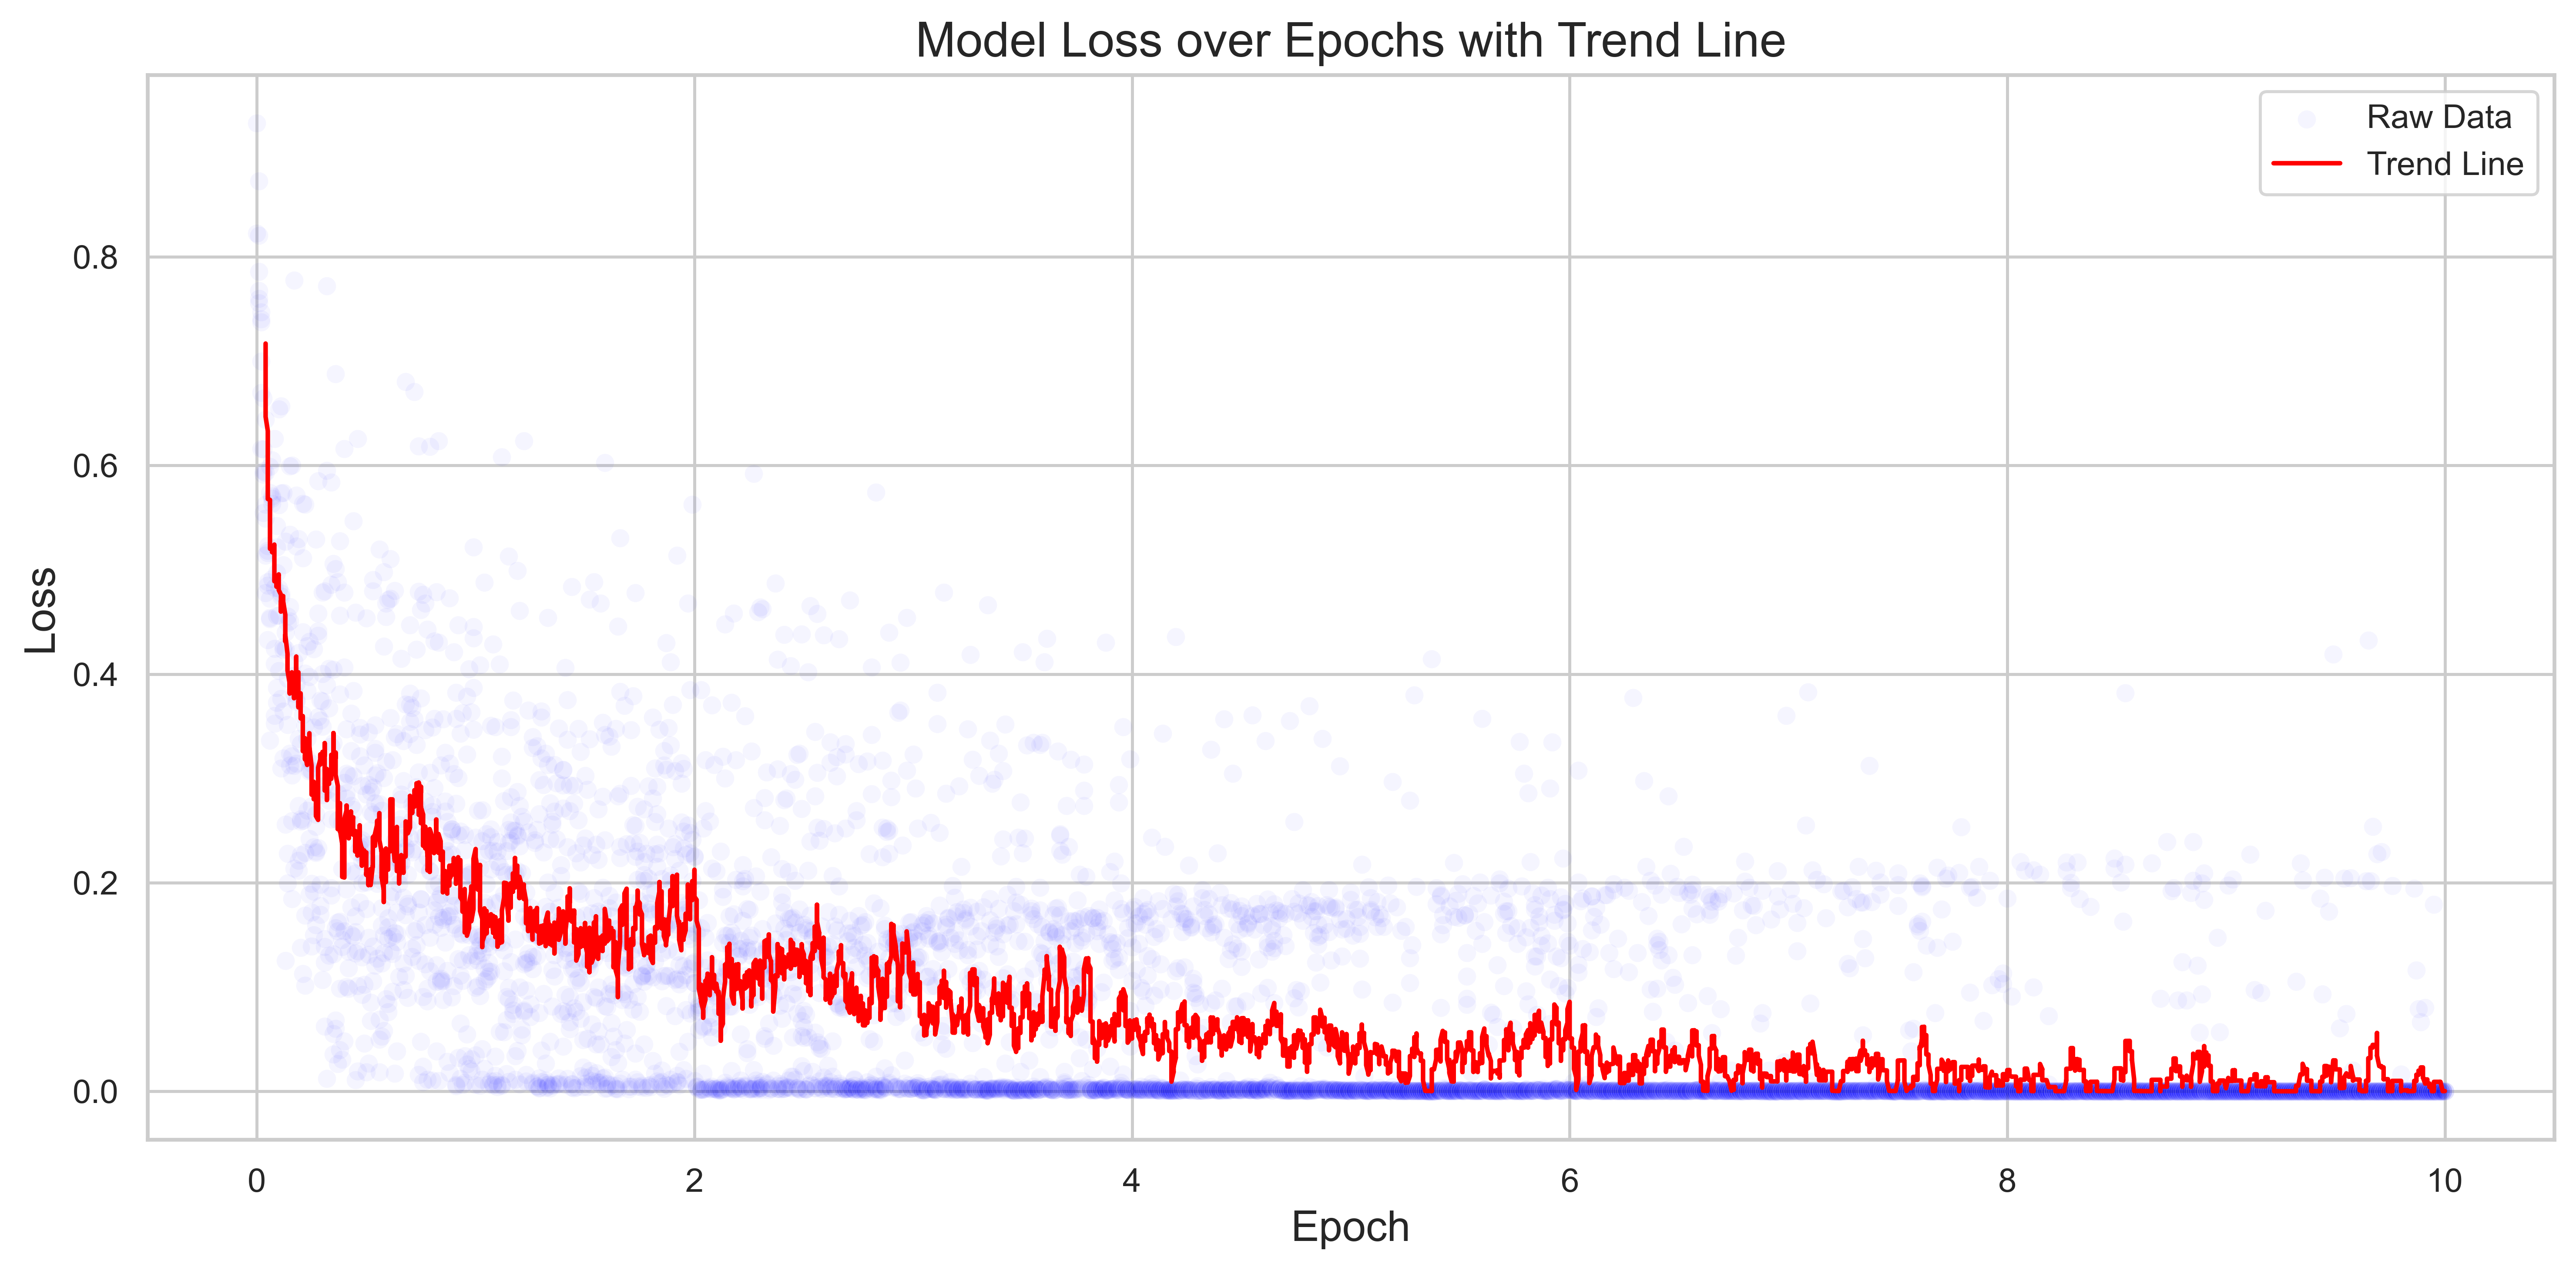

In [12]:
# Prepare data for plotting by converting it to a DataFrame
data = pd.DataFrame(trainer.state.log_history)

# Filter out rows where 'epoch' or 'loss' is missing
data = data.dropna(subset=['epoch', 'loss'])

# Set the seaborn theme
sns.set_theme(style="whitegrid")

# Create the plot with a figure size suitable for professional presentations
plt.figure(figsize=(12, 6))

# Plot the raw data points with transparency
sns.scatterplot(x='epoch', y='loss', data=data, alpha=0.04, label='Raw Data', color='blue')

# Calculate the rolling mean for a smooth trend line
rolling_mean = data['loss'].rolling(window=20).mean()

# Plot the trend line
plt.plot(data['epoch'], rolling_mean, color='red', label='Trend Line')

# Enhance the plot
plt.title('Model Loss over Epochs with Trend Line', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

In [13]:
pred_labels = np.argmax(trainer.predict(test_dataset).predictions, axis=1)

100%|██████████| 356/356 [01:52<00:00,  3.17it/s]


In [17]:
accuracy = accuracy_score(y_test, pred_labels)
print(f"Accuracy: {accuracy * 100}%")

Accuracy: 82.92939936775554%


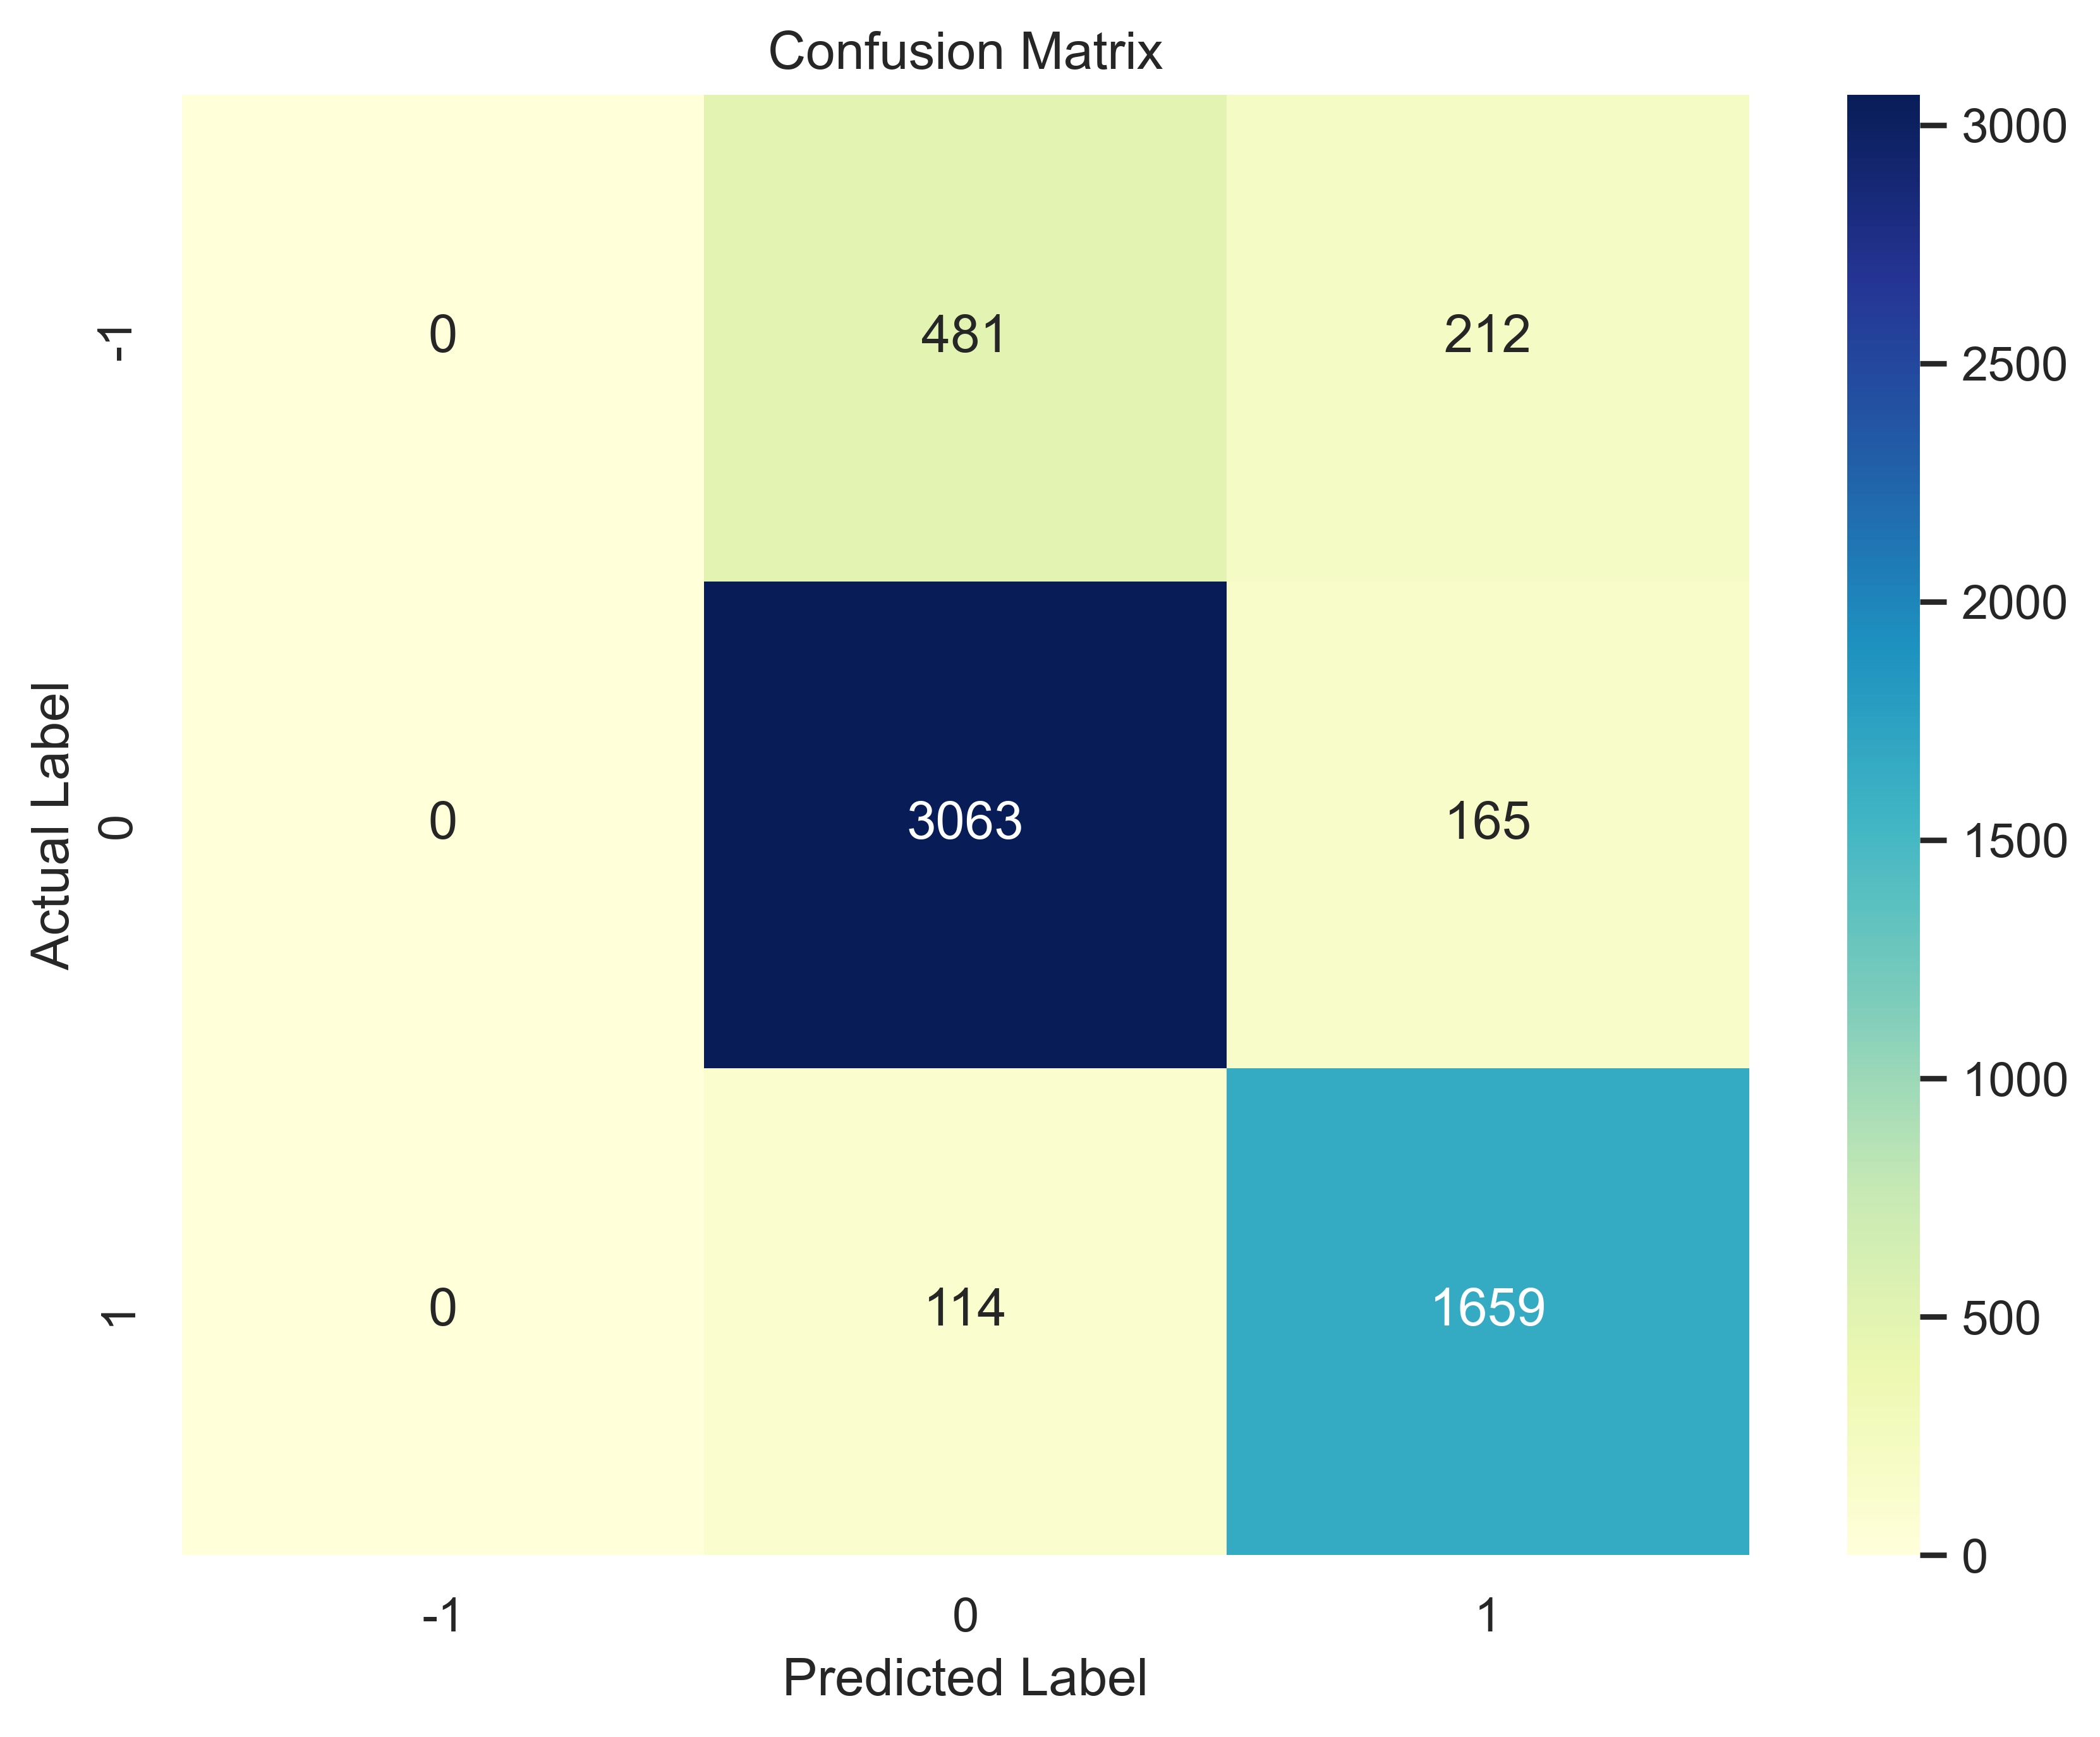

Confusion Matrix:
 [[   0  481  212]
 [   0 3063  165]
 [   0  114 1659]]


In [15]:
original_labels = [-1, 0, 1]

# Confusion Matrix
cm = confusion_matrix(y_test, pred_labels)

# Plotting the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap="YlGnBu", xticklabels=original_labels, yticklabels=original_labels)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Display the confusion matrix
print("Confusion Matrix:\n", cm)

In [16]:
# Classification Report
print(classification_report(y_test, pred_labels))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       693
           0       0.84      0.95      0.89      3228
           1       0.81      0.94      0.87      1773

    accuracy                           0.83      5694
   macro avg       0.55      0.63      0.59      5694
weighted avg       0.73      0.83      0.78      5694



/Users/josh/Desktop/Coding 👨🏽‍💻/sentiment_analysis/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/josh/Desktop/Coding 👨🏽‍💻/sentiment_analysis/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/josh/Desktop/Coding 👨🏽‍💻/sentiment_analysis/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th